# **Spotify Virality Prediction**
Made by: Douae BAKKALI & Omar BEHRI
### Data Source:
[Spotify Tracks Dataset on Kaggle](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset?resource=download)

### Project Objective:
The goal of this project is to predict whether a song will be popular based on features derived from the Spotify API. The key challenge lies in the time-sensitive nature of the data. Since the dataset is from 2021-2022, the model's predictions are tied to trends of that period.

### Key Challenge:
Given that the data reflects trends from 2021-2022, an accurate title for this project could be:  
**"Would This Song Have Been Popular in 2021-2022?"**  
The popularity of songs is highly dependent on what is popular at a given time, and the trends can change rapidly. This makes the task of predicting virality inherently dynamic and tied to the specific time window of the data.

In [1]:
%pip install numpy pandas matplotlib seaborn plotly scikit-learn tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import platform
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn import datasets, decomposition, metrics, preprocessing, utils, pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from matplotlib.image import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score




In [3]:


%config InlineBackend.figure_format="retina"  # For high DPI display

sns.set_style("darkgrid")
sns.set_context("notebook")

plotly.offline.init_notebook_mode(connected=True)

tqdm.pandas()

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.5.x

1.6.1


In [4]:
def pprint_var(**kwargs):
    for k, v in kwargs.items():
        print(f"{k} = {v:.4g}")

In [5]:


DATA = Path("C:/Users/Asus/Documents/Dataset")    # change to local folder


In [6]:
spotify_original = pd.read_csv(DATA /"dataset.csv", low_memory=False, index_col=0)

In [7]:


spotify_df = spotify_original.copy()

We keep the original dataset and work on `spotify_df`.

# **Preprocessing/ Data Cleaning**

Dataset import and general information

In [8]:
spotify_df.info()
spotify_df.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

track_id                 artists        album_name  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino            Comedy   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward  Ghost (Acoustic)   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN    To Begin Again   

         track_name  popularity  duration_ms  explicit  danceability  energy  \
0            Comedy          73       230666     False         0.676   0.461   
1  Ghost - Acoustic          55       149610     False         0.420   0.166   
2    To Begin Again          57       210826     False         0.438   0.359   

   key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    1    -6.746     0       0.1430        0.0322          0.000001     0.358   
1    1   -17.235     1       0.0763        0.9240          0.000006     0.101   
2    0    -9.734     1       0.0557        0.2100          0.000000     0.117   

   valence   tempo  time_signature track_genre  
0    0.715  87.917               4    acoustic  
1    0.267  77.489               4    acoustic  
2    0.120  76.332               4    acoustic

In [9]:
spotify_df.shape

(114000, 20)

Let's start preprocessing our dataset.

First we handle missing values.

In [10]:
# how many missing values
spotify_df.isna().sum()

# identify rows with missing values
spotify_df[spotify_df.isna().any(axis=1)]

track_id artists album_name track_name  popularity  \
65900  1kR4gIb7nGxHPI3D2ifs59     NaN        NaN        NaN           0   

       duration_ms  explicit  danceability  energy  key  loudness  mode  \
65900            0     False         0.501   0.583    7     -9.46     0   

       speechiness  acousticness  instrumentalness  liveness  valence  \
65900       0.0605          0.69           0.00396    0.0747    0.734   

         tempo  time_signature track_genre  
65900  138.391               4       k-pop

One row of missing values will not impact the outcome of our models. So we decided to delete it.

In [11]:
# delete the row with missing values and reset index
spotify_df.dropna(axis="index", inplace=True)
spotify_df.reset_index(drop=True, inplace=True)

Let's search now for duplicated songs ( i.e. songs with exact values for all of the features)

In [12]:
# we see for this specific song, the two first lines are totally the same
spotify_df[spotify_df["track_id"]=="3JiRG3zjef1biea1lH8MJ3"]

# we drop the duplicates
spotify_df.drop_duplicates(inplace=True)
spotify_df.reset_index(drop=True, inplace=True)

Our dataset contains both qualitative and quantitative features with different types (Boolean, numerical, strings...). The goal is to have only numerical values in our dataset. In order to do that, we need to handle each feature depending on its type, starting from the `explicit` feature which is a boolean.  

In [13]:
#Handling 'explicit' feature
# convert bool into 0-1 // False : 0, True : 1
spotify_df['explicit'] = spotify_df['explicit']*1
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113549 entries, 0 to 113548
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          113549 non-null  object 
 1   artists           113549 non-null  object 
 2   album_name        113549 non-null  object 
 3   track_name        113549 non-null  object 
 4   popularity        113549 non-null  int64  
 5   duration_ms       113549 non-null  int64  
 6   explicit          113549 non-null  int64  
 7   danceability      113549 non-null  float64
 8   energy            113549 non-null  float64
 9   key               113549 non-null  int64  
 10  loudness          113549 non-null  float64
 11  mode              113549 non-null  int64  
 12  speechiness       113549 non-null  float64
 13  acousticness      113549 non-null  float64
 14  instrumentalness  113549 non-null  float64
 15  liveness          113549 non-null  float64
 16  valence           11

We can also see that each track has as primary key the feature `track_id`, but one song can belong to multiple genres.
So we are going to group by `track_id` and add one column for each genre. For these columns, we'll use 0-1 classification like the `explicit` feature. Same thing is done with `key`and `time_signature`.

In [14]:
# Convert 'key' and 'time_signature' columns to dummy variables
key_dummies = pd.get_dummies(spotify_df['key'], prefix='key')
time_signature_dummies = pd.get_dummies(spotify_df['time_signature'], prefix='time_signature')

# Concatenate dummy variables with the original DataFrame
spotify_df = pd.concat([spotify_df, key_dummies, time_signature_dummies], axis=1)

col_dummieskey = []
for i in range(12) :
    col_dummieskey.append("key_"+str(i))
print(col_dummieskey)
col_dummiestime = []
for i in [0, 1, 3, 4, 5] :
    col_dummiestime.append("time_signature_"+str(i))


spotify_df[col_dummieskey] = spotify_df[col_dummieskey]*1
spotify_df[col_dummiestime] = spotify_df[col_dummiestime]*1


# Drop the original 'key' and 'time_signature' columns
spotify_df.drop(['key', 'time_signature'], axis=1, inplace=True)
spotify_df.head(3)

['key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11']


track_id                 artists        album_name  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino            Comedy   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward  Ghost (Acoustic)   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN    To Begin Again   

         track_name  popularity  duration_ms  explicit  danceability  energy  \
0            Comedy          73       230666         0         0.676   0.461   
1  Ghost - Acoustic          55       149610         0         0.420   0.166   
2    To Begin Again          57       210826         0         0.438   0.359   

   loudness  ...  key_7  key_8  key_9  key_10  key_11  time_signature_0  \
0    -6.746  ...      0      0      0       0       0                 0   
1   -17.235  ...      0      0      0       0       0                 0   
2    -9.734  ...      0      0      0       0       0                 0   

   time_signature_1 time_signature_3  time_signature_4  time_signature_5  
0                 0                0                 1                 0  
1                 0                0                 1                 0  
2                 0                0                 1                 0  

[3 rows x 35 columns]

In [15]:
# list the different genres
genres = list(set(spotify_df["track_genre"].values))
print(len(genres)) # 114 genres

# create a specific dataframe for genre preprocessing
genre_df = spotify_df[["track_id", "track_genre"]]
genre_df.info()

# drop non-musical features and duplicate songs by `track_id`
spotify_df.drop(columns=["track_genre", "artists", "album_name", "track_name"], inplace=True)
spotify_df.drop_duplicates(subset=["track_id"], keep="last", inplace=True)

# convert the track_genre columns into several 0-1 columns
genre_df = pd.get_dummies(genre_df, prefix=["track_genre"], columns=["track_genre"])*1
genre_df.head(3)

114
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113549 entries, 0 to 113548
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   track_id     113549 non-null  object
 1   track_genre  113549 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


track_id  track_genre_acoustic  track_genre_afrobeat  \
0  5SuOikwiRyPMVoIQDJUgSV                     1                     0   
1  4qPNDBW1i3p13qLCt0Ki3A                     1                     0   
2  1iJBSr7s7jYXzM8EGcbK5b                     1                     0   

   track_genre_alt-rock  track_genre_alternative  track_genre_ambient  \
0                     0                        0                    0   
1                     0                        0                    0   
2                     0                        0                    0   

   track_genre_anime  track_genre_black-metal  track_genre_bluegrass  \
0                  0                        0                      0   
1                  0                        0                      0   
2                  0                        0                      0   

   track_genre_blues  ...  track_genre_spanish  track_genre_study  \
0                  0  ...                    0                  0   
1                  0  ...                    0                  0   
2                  0  ...                    0                  0   

   track_genre_swedish  track_genre_synth-pop  track_genre_tango  \
0                    0                      0                  0   
1                    0                      0                  0   
2                    0                      0                  0   

   track_genre_techno  track_genre_trance  track_genre_trip-hop  \
0                   0                   0                     0   
1                   0                   0                     0   
2                   0                   0                     0   

   track_genre_turkish  track_genre_world-music  
0                    0                        0  
1                    0                        0  
2                    0                        0  

[3 rows x 115 columns]

In [16]:
# list of new columns' name
col_genre = []
for i in range(len(genres)) :
    col_genre.append("track_genre_"+genres[i])

# group by track_id and sum the genres columns
grouped_data = genre_df.groupby('track_id', as_index=True)[col_genre].sum()
grouped_data.reset_index(inplace=True)
# describe the new dataframe with full columns
pd.set_option('display.max_columns',None)
grouped_data.describe()

C:\Users\Asus\AppData\Local\Temp\ipykernel_11744\1438038710.py:8: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



track_genre_new-age  track_genre_k-pop  track_genre_r-n-b  \
count         89740.000000       89740.000000       89740.000000   
mean              0.011076           0.011121           0.011143   
std               0.104661           0.104869           0.104973   
min               0.000000           0.000000           0.000000   
25%               0.000000           0.000000           0.000000   
50%               0.000000           0.000000           0.000000   
75%               0.000000           0.000000           0.000000   
max               1.000000           1.000000           1.000000   

       track_genre_british  track_genre_cantopop  track_genre_opera  \
count         89740.000000          89740.000000       89740.000000   
mean              0.011143              0.011132           0.011054   
std               0.104973              0.104921           0.104557   
min               0.000000              0.000000           0.000000   
25%               0.000000              0.000000           0.000000   
50%               0.000000              0.000000           0.000000   
75%               0.000000              0.000000           0.000000   
max               1.000000              1.000000           1.000000   

       track_genre_forro  track_genre_swedish  track_genre_detroit-techno  \
count       89740.000000         89740.000000                89740.000000   
mean            0.011121             0.011143                    0.011121   
std             0.104869             0.104973                    0.104869   
min             0.000000             0.000000                    0.000000   
25%             0.000000             0.000000                    0.000000   
50%             0.000000             0.000000                    0.000000   
75%             0.000000             0.000000                    0.000000   
max             1.000000             1.000000                    1.000000   

       track_genre_show-tunes  track_genre_pop  track_genre_hard-rock  \
count            89740.000000     89740.000000           89740.000000   
mean                 0.011132         0.011065               0.011121   
std                  0.104921         0.104609               0.104869   
min                  0.000000         0.000000               0.000000   
25%                  0.000000         0.000000               0.000000   
50%                  0.000000         0.000000               0.000000   
75%                  0.000000         0.000000               0.000000   
max                  1.000000         1.000000               1.000000   

       track_genre_electronic  track_genre_kids  track_genre_sad  \
count            89740.000000      89740.000000     89740.000000   
mean                 0.011143          0.011043         0.011143   
std                  0.104973          0.104504         0.104973   
min                  0.000000          0.000000         0.000000   
25%                  0.000000          0.000000         0.000000   
50%                  0.000000          0.000000         0.000000   
75%                  0.000000          0.000000         0.000000   
max                  1.000000          1.000000         1.000000   

       track_genre_synth-pop  track_genre_trip-hop  track_genre_industrial  \
count           89740.000000          89740.000000            89740.000000   
mean                0.011143              0.011110                0.011143   
std                 0.104973              0.104817                0.104973   
min                 0.000000              0.000000                0.000000   
25%                 0.000000              0.000000                0.000000   
50%                 0.000000              0.000000                0.000000   
75%                 0.000000              0.000000                0.000000   
max                 1.000000              1.000000                1.000000   

       track_genre_punk-rock  track_genre_malay  track_genre_metalcore  \
count       

The first time we group by `track_id` we see that we have 2 in our 0-1 columns. To fix this, we drop duplicates. Now we can see that the max for each genre feature is 1.

It is time to merge `spotify_df` and `grouped_data`, after that we will drop `track_id`.
Our new dataframe is ready for EDA and model training.

In [17]:
spotify_df = pd.merge(spotify_df, grouped_data, on="track_id")
spotify_df.drop(columns="track_id", inplace=True)
spotify_df.info()
spotify_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89740 entries, 0 to 89739
Columns: 144 entries, popularity to track_genre_death-metal
dtypes: float64(9), int64(135)
memory usage: 98.6 MB


popularity  duration_ms  explicit  danceability  energy  loudness  \
0              57       210826         0         0.438  0.3590    -9.734   
1              71       201933         0         0.266  0.0596   -18.515   
2              82       198853         0         0.618  0.4430    -9.681   
3              74       189613         0         0.625  0.4140    -8.700   
4              74       244800         0         0.627  0.3630    -8.127   
...           ...          ...       ...           ...     ...       ...   
89735          21       384999         0         0.172  0.2350   -16.393   
89736          22       385000         0         0.174  0.1170   -18.318   
89737          22       271466         0         0.629  0.3290   -10.895   
89738          41       283893         0         0.587  0.5060   -10.889   
89739          22       241826         0         0.526  0.4870   -10.204   

       mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0         1       0.0557         0.210          0.000000    0.1170   0.1200   
1         1       0.0363         0.905          0.000071    0.1320   0.1430   
2         1       0.0526         0.469          0.000000    0.0829   0.1670   
3         1       0.0369         0.294          0.000000    0.1510   0.6690   
4         1       0.0291         0.279          0.000000    0.0928   0.3010   
...     ...          ...           ...               ...       ...      ...   
89735     1       0.0422         0.640          0.928000    0.0863   0.0339   
89736     0       0.0401         0.994          0.976000    0.1050   0.0350   
89737     0       0.0420         0.867          0.000000    0.0839   0.7430   
89738     1       0.0297         0.381          0.000000    0.2700   0.4130   
89739     0       0.0725         0.681          0.000000    0.0893   0.7080   

         tempo  key_0  key_1  key_2  key_3  key_4  key_5  key_6  key_7  key_8  \
0       76.332      1      0      0      0      0      0      0      0      0   
1      181.740      1      0      0      0      0      0      0      0      0   
2      119.949      0      0      1      0      0      0      0      0      0   
3      130.088      1      0      0      0      0      0      0      0      0   
4       99.905      0      0      0      0      0      0      0      0      1   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
89735  125.995      0      0      0      0      0      1      0      0      0   
89736   85.239      1      0      0      0      0      0      0      0      0   
89737  132.378      1      0      0      0      0      0      0      0      0   
89738  135.960      0      0      0      0      0      0      0      1      0   
89739   79.198      0      1      0      0      0      0      0      0      0   

       key_9  key_10  key_11  time_signature_0  time_signature_1  \
0          0       0       0                 0                 0   
1          0       0       0                 0                 0   
2          0       0       0                 0                 0   
3          0       0       0                 0                 0   
4          0       0       0                 0                 0   
...      ...     ...     ...               ...               ...   
89735      0       0       0                 0                 0   
89736      0       0       0                 0                 0   
89737      0       0       0                 0                 0   
89738      0       0       0                 0                 0   
89739      0       0       0                 0                 0   

       time_signature_3  time_signature_4  time_signature_5  \
0                     0                 1                 0   
1                     1                 0                 0   
2                     0                 1                 0   
3                     0                 1                 0   
4                     0                 

For regression models, we will try to predict popularity (numerical 0-100) with the other features.

And for classification models, we will use popularity_flag to class track into 1 : popular song and 0 : non-popular song. we arbitrarily set the threshold at 50 at first (we will change it later to 40 for a reason)

In [18]:
spotify_df["popularity_flag"] = 0
spotify_df.loc[spotify_df["popularity"] >= 50, "popularity_flag"] = 1
spotify_df.info()
spotify_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89740 entries, 0 to 89739
Columns: 145 entries, popularity to popularity_flag
dtypes: float64(9), int64(136)
memory usage: 99.3 MB


popularity  duration_ms  explicit  danceability  energy  loudness  \
0              57       210826         0         0.438  0.3590    -9.734   
1              71       201933         0         0.266  0.0596   -18.515   
2              82       198853         0         0.618  0.4430    -9.681   
3              74       189613         0         0.625  0.4140    -8.700   
4              74       244800         0         0.627  0.3630    -8.127   
...           ...          ...       ...           ...     ...       ...   
89735          21       384999         0         0.172  0.2350   -16.393   
89736          22       385000         0         0.174  0.1170   -18.318   
89737          22       271466         0         0.629  0.3290   -10.895   
89738          41       283893         0         0.587  0.5060   -10.889   
89739          22       241826         0         0.526  0.4870   -10.204   

       mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0         1       0.0557         0.210          0.000000    0.1170   0.1200   
1         1       0.0363         0.905          0.000071    0.1320   0.1430   
2         1       0.0526         0.469          0.000000    0.0829   0.1670   
3         1       0.0369         0.294          0.000000    0.1510   0.6690   
4         1       0.0291         0.279          0.000000    0.0928   0.3010   
...     ...          ...           ...               ...       ...      ...   
89735     1       0.0422         0.640          0.928000    0.0863   0.0339   
89736     0       0.0401         0.994          0.976000    0.1050   0.0350   
89737     0       0.0420         0.867          0.000000    0.0839   0.7430   
89738     1       0.0297         0.381          0.000000    0.2700   0.4130   
89739     0       0.0725         0.681          0.000000    0.0893   0.7080   

         tempo  key_0  key_1  key_2  key_3  key_4  key_5  key_6  key_7  key_8  \
0       76.332      1      0      0      0      0      0      0      0      0   
1      181.740      1      0      0      0      0      0      0      0      0   
2      119.949      0      0      1      0      0      0      0      0      0   
3      130.088      1      0      0      0      0      0      0      0      0   
4       99.905      0      0      0      0      0      0      0      0      1   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
89735  125.995      0      0      0      0      0      1      0      0      0   
89736   85.239      1      0      0      0      0      0      0      0      0   
89737  132.378      1      0      0      0      0      0      0      0      0   
89738  135.960      0      0      0      0      0      0      0      1      0   
89739   79.198      0      1      0      0      0      0      0      0      0   

       key_9  key_10  key_11  time_signature_0  time_signature_1  \
0          0       0       0                 0                 0   
1          0       0       0                 0                 0   
2          0       0       0                 0                 0   
3          0       0       0                 0                 0   
4          0       0       0                 0                 0   
...      ...     ...     ...               ...               ...   
89735      0       0       0                 0                 0   
89736      0       0       0                 0                 0   
89737      0       0       0                 0                 0   
89738      0       0       0                 0                 0   
89739      0       0       0                 0                 0   

       time_signature_3  time_signature_4  time_signature_5  \
0                     0                 1                 0   
1                     1                 0                 0   
2                     0                 1                 0   
3                     0                 1                 0   
4                     0                 

Now we can create a new scaled version of our dataset, because there are differents units and scales. In order to do that, we used `StandardScaler`and `MinMaxScaler`

Howewer, some algorithms based on trees are not scale-sensitive like Random Forest.

In [19]:
# we use standard scaler
stdscaler = preprocessing.StandardScaler()
y_target = spotify_df["popularity_flag"]
#set qualitative features col_qualitative as col_genre plus col_dummiestime plus col_dummieskey
col_qualitative = col_genre + col_dummiestime + col_dummieskey
qualitative_df = spotify_df[col_qualitative]
qualitative_df['popularity_flag'] = y_target

quantitative_df = spotify_df.drop(columns=col_qualitative)
quantitative_df.drop(columns="popularity_flag", inplace=True)

scaled_df = pd.DataFrame(stdscaler.fit_transform(quantitative_df), columns=quantitative_df.columns, index=quantitative_df.index)
scaled_df = pd.concat([scaled_df, qualitative_df], axis=1)

scaled_df.describe()

C:\Users\Asus\AppData\Local\Temp\ipykernel_11744\3047557178.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



popularity   duration_ms      explicit  danceability        energy  \
count  8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04   
mean  -2.533694e-18 -7.601081e-17 -7.221027e-17  5.308088e-16 -8.867928e-18   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -1.614106e+00 -1.952792e+00 -3.064474e-01 -3.181635e+00 -2.472511e+00   
25%   -6.904461e-01 -4.967399e-01 -3.064474e-01 -6.348163e-01 -6.915629e-01   
50%   -9.854376e-03 -1.403236e-01 -3.064474e-01  7.829285e-02  1.618890e-01   
75%    7.679647e-01  3.112009e-01 -3.064474e-01  7.348060e-01  8.516653e-01   
max    3.247263e+00  4.434144e+01  3.263203e+00  2.393068e+00  1.424530e+00   

           loudness          mode   speechiness  acousticness  \
count  8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04   
mean   2.128303e-16 -1.773586e-17 -2.153640e-16  1.621564e-16   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -7.858297e+00 -1.324621e+00 -7.719334e-01 -9.703424e-01   
25%   -3.491832e-01 -1.324621e+00 -4.541285e-01 -9.197984e-01   
50%    2.516512e-01  7.549332e-01 -3.402484e-01 -4.146533e-01   
75%    6.494305e-01  7.549332e-01 -1.361559e-02  8.770282e-01   
max    2.495647e+00  7.549332e-01  7.747003e+00  1.973627e+00   

       instrumentalness      liveness       valence         tempo  \
count      8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04   
mean      -1.520216e-16 -2.407009e-17  1.824259e-16  7.977968e-16   
std        1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min       -5.354847e-01 -1.113336e+00 -1.786011e+00 -4.052734e+00   
25%       -5.354847e-01 -6.094458e-01 -8.387457e-01 -7.568821e-01   
50%       -5.353056e-01 -4.360091e-01 -4.745621e-02 -1.498606e-03   
75%       -2.340311e-01  3.182866e-01  8.085060e-01  5.982859e-01   
max        2.552389e+00  4.017927e+00  1.999245e+00  4.028021e+00   

       track_genre_new-age  track_genre_k-pop  track_genre_r-n-b  \
count         89740.000000       89740.000000       89740.000000   
mean              0.011076           0.011121           0.011143   
std               0.104661           0.104869           0.104973   
min               0.000000           0.000000           0.000000   
25%               0.000000           0.000000           0.000000   
50%               0.000000           0.000000           0.000000   
75%               0.000000           0.000000           0.000000   
max               1.000000           1.000000           1.000000   

       track_genre_british  track_genre_cantopop  track_genre_opera  \
count         89740.000000          89740.000000       89740.000000   
mean              0.011143              0.011132           0.011054   
std               0.104973              0.104921           0.104557   
min               0.000000              0.000000           0.000000   
25%               0.000000              0.000000           0.000000   
50%               0.000000              0.000000           0.000000   
75%               0.000000              0.000000           0.000000   
max               1.000000              1.000000           1.000000   

       track_genre_forro  track_genre_swedish  track_genre_detroit-techno  \
count       89740.000000         89740.000000                89740.000000   
mean            0.011121             0.011143                    0.011121   
std             0.104869             0.104973                    0.104869   
min             0.000000             0.000000                    0.000000   
25%             0.000000             0.000000                    0.000000   
50%             0.000000             0.000000                    0.000000   
75%             0.000000             0.000000                    0.000000   
max             1.000000             1.000000                    1.000000   

       track_genre_show-tunes  track_genre_pop  track_genre_hard-rock  \
count            89740.000000     89740.000000           89740.000000

In [20]:
# and min max scaler
minmaxscaler = preprocessing.MinMaxScaler()
y_target = spotify_df["popularity_flag"]


minmax_df = pd.DataFrame(minmaxscaler.fit_transform(spotify_df), columns=spotify_df.columns, index=spotify_df.index)

minmax_df.describe()


popularity   duration_ms      explicit  danceability        energy  \
count  89740.000000  89740.000000  89740.000000  89740.000000  89740.000000   
mean       0.332027      0.042182      0.085848      0.570727      0.634458   
std        0.205704      0.021601      0.280141      0.179383      0.256606   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.190000      0.031452      0.000000      0.456853      0.457000   
50%        0.330000      0.039151      0.000000      0.584772      0.676000   
75%        0.490000      0.048904      0.000000      0.702538      0.853000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           loudness          mode   speechiness  acousticness  \
count  89740.000000  89740.000000  89740.000000  89740.000000   
mean       0.758967      0.636973      0.090614      0.329603   
std        0.096582      0.480875      0.117386      0.339679   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.725242      0.000000      0.037306      0.017169   
50%        0.783271      1.000000      0.050674      0.188755   
75%        0.821690      1.000000      0.089016      0.627510   
max        1.000000      1.000000      1.000000      1.000000   

       instrumentalness      liveness       valence         tempo  \
count      89740.000000  89740.000000  89740.000000  89740.000000   
mean           0.173415      0.216971      0.471834      0.501529   
std            0.323849      0.194885      0.264184      0.123752   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.098200      0.250251      0.407864   
50%            0.000058      0.132000      0.459296      0.501344   
75%            0.097625      0.279000      0.685427      0.575567   
max            1.000000      1.000000      1.000000      1.000000   

              key_0         key_1         key_2         key_3         key_4  \
count  89740.000000  89740.000000  89740.000000  89740.000000  89740.000000   
mean       0.115355      0.095565      0.103934      0.030856      0.079485   
std        0.319452      0.293995      0.305176      0.172928      0.270496   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              key_5         key_6         key_7         key_8         key_9  \
count  89740.000000  89740.000000  89740.000000  89740.000000  89740.000000   
mean       0.081435      0.068409      0.117562      0.062068      0.100267   
std        0.273504      0.252447      0.322090      0.241281      0.300358   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             key_10        key_11  time_signature_0  time_signature_1  \
count  89740.000000  89740.000000      89740.000000      89740.000000   
mean       0.065623      0.079441          0.001805          0.009427   
std        0.247623      0.270427          0.042450          0.096636   
min        0.000000      0.000000          0.000000          0.000000   
25%        0.000000      0.000000          0.000000          0.000000   
50%        0.000000      0.000000          0.000000          0.000000   
75%        0.000000      0.000000          0.000000          0.000000   
max        1.000000      1.000000          1.000000          1.000000   

       

# **Exploratory Analysis (EDA)**

**Summary Statistics:**

Let's see the statistics of our standardized dataframe. Obviously, the mean is at 0 and Standard Deviation is at 1

In [21]:
scaled_df.describe()

popularity   duration_ms      explicit  danceability        energy  \
count  8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04   
mean  -2.533694e-18 -7.601081e-17 -7.221027e-17  5.308088e-16 -8.867928e-18   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -1.614106e+00 -1.952792e+00 -3.064474e-01 -3.181635e+00 -2.472511e+00   
25%   -6.904461e-01 -4.967399e-01 -3.064474e-01 -6.348163e-01 -6.915629e-01   
50%   -9.854376e-03 -1.403236e-01 -3.064474e-01  7.829285e-02  1.618890e-01   
75%    7.679647e-01  3.112009e-01 -3.064474e-01  7.348060e-01  8.516653e-01   
max    3.247263e+00  4.434144e+01  3.263203e+00  2.393068e+00  1.424530e+00   

           loudness          mode   speechiness  acousticness  \
count  8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04   
mean   2.128303e-16 -1.773586e-17 -2.153640e-16  1.621564e-16   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -7.858297e+00 -1.324621e+00 -7.719334e-01 -9.703424e-01   
25%   -3.491832e-01 -1.324621e+00 -4.541285e-01 -9.197984e-01   
50%    2.516512e-01  7.549332e-01 -3.402484e-01 -4.146533e-01   
75%    6.494305e-01  7.549332e-01 -1.361559e-02  8.770282e-01   
max    2.495647e+00  7.549332e-01  7.747003e+00  1.973627e+00   

       instrumentalness      liveness       valence         tempo  \
count      8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04   
mean      -1.520216e-16 -2.407009e-17  1.824259e-16  7.977968e-16   
std        1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min       -5.354847e-01 -1.113336e+00 -1.786011e+00 -4.052734e+00   
25%       -5.354847e-01 -6.094458e-01 -8.387457e-01 -7.568821e-01   
50%       -5.353056e-01 -4.360091e-01 -4.745621e-02 -1.498606e-03   
75%       -2.340311e-01  3.182866e-01  8.085060e-01  5.982859e-01   
max        2.552389e+00  4.017927e+00  1.999245e+00  4.028021e+00   

       track_genre_new-age  track_genre_k-pop  track_genre_r-n-b  \
count         89740.000000       89740.000000       89740.000000   
mean              0.011076           0.011121           0.011143   
std               0.104661           0.104869           0.104973   
min               0.000000           0.000000           0.000000   
25%               0.000000           0.000000           0.000000   
50%               0.000000           0.000000           0.000000   
75%               0.000000           0.000000           0.000000   
max               1.000000           1.000000           1.000000   

       track_genre_british  track_genre_cantopop  track_genre_opera  \
count         89740.000000          89740.000000       89740.000000   
mean              0.011143              0.011132           0.011054   
std               0.104973              0.104921           0.104557   
min               0.000000              0.000000           0.000000   
25%               0.000000              0.000000           0.000000   
50%               0.000000              0.000000           0.000000   
75%               0.000000              0.000000           0.000000   
max               1.000000              1.000000           1.000000   

       track_genre_forro  track_genre_swedish  track_genre_detroit-techno  \
count       89740.000000         89740.000000                89740.000000   
mean            0.011121             0.011143                    0.011121   
std             0.104869             0.104973                    0.104869   
min             0.000000             0.000000                    0.000000   
25%             0.000000             0.000000                    0.000000   
50%             0.000000             0.000000                    0.000000   
75%             0.000000             0.000000                    0.000000   
max             1.000000             1.000000                    1.000000   

       track_genre_show-tunes  track_genre_pop  track_genre_hard-rock  \
count            89740.000000     89740.000000           89740.000000

Let's plot some univariate data analysis (using the original duplicated dataset).

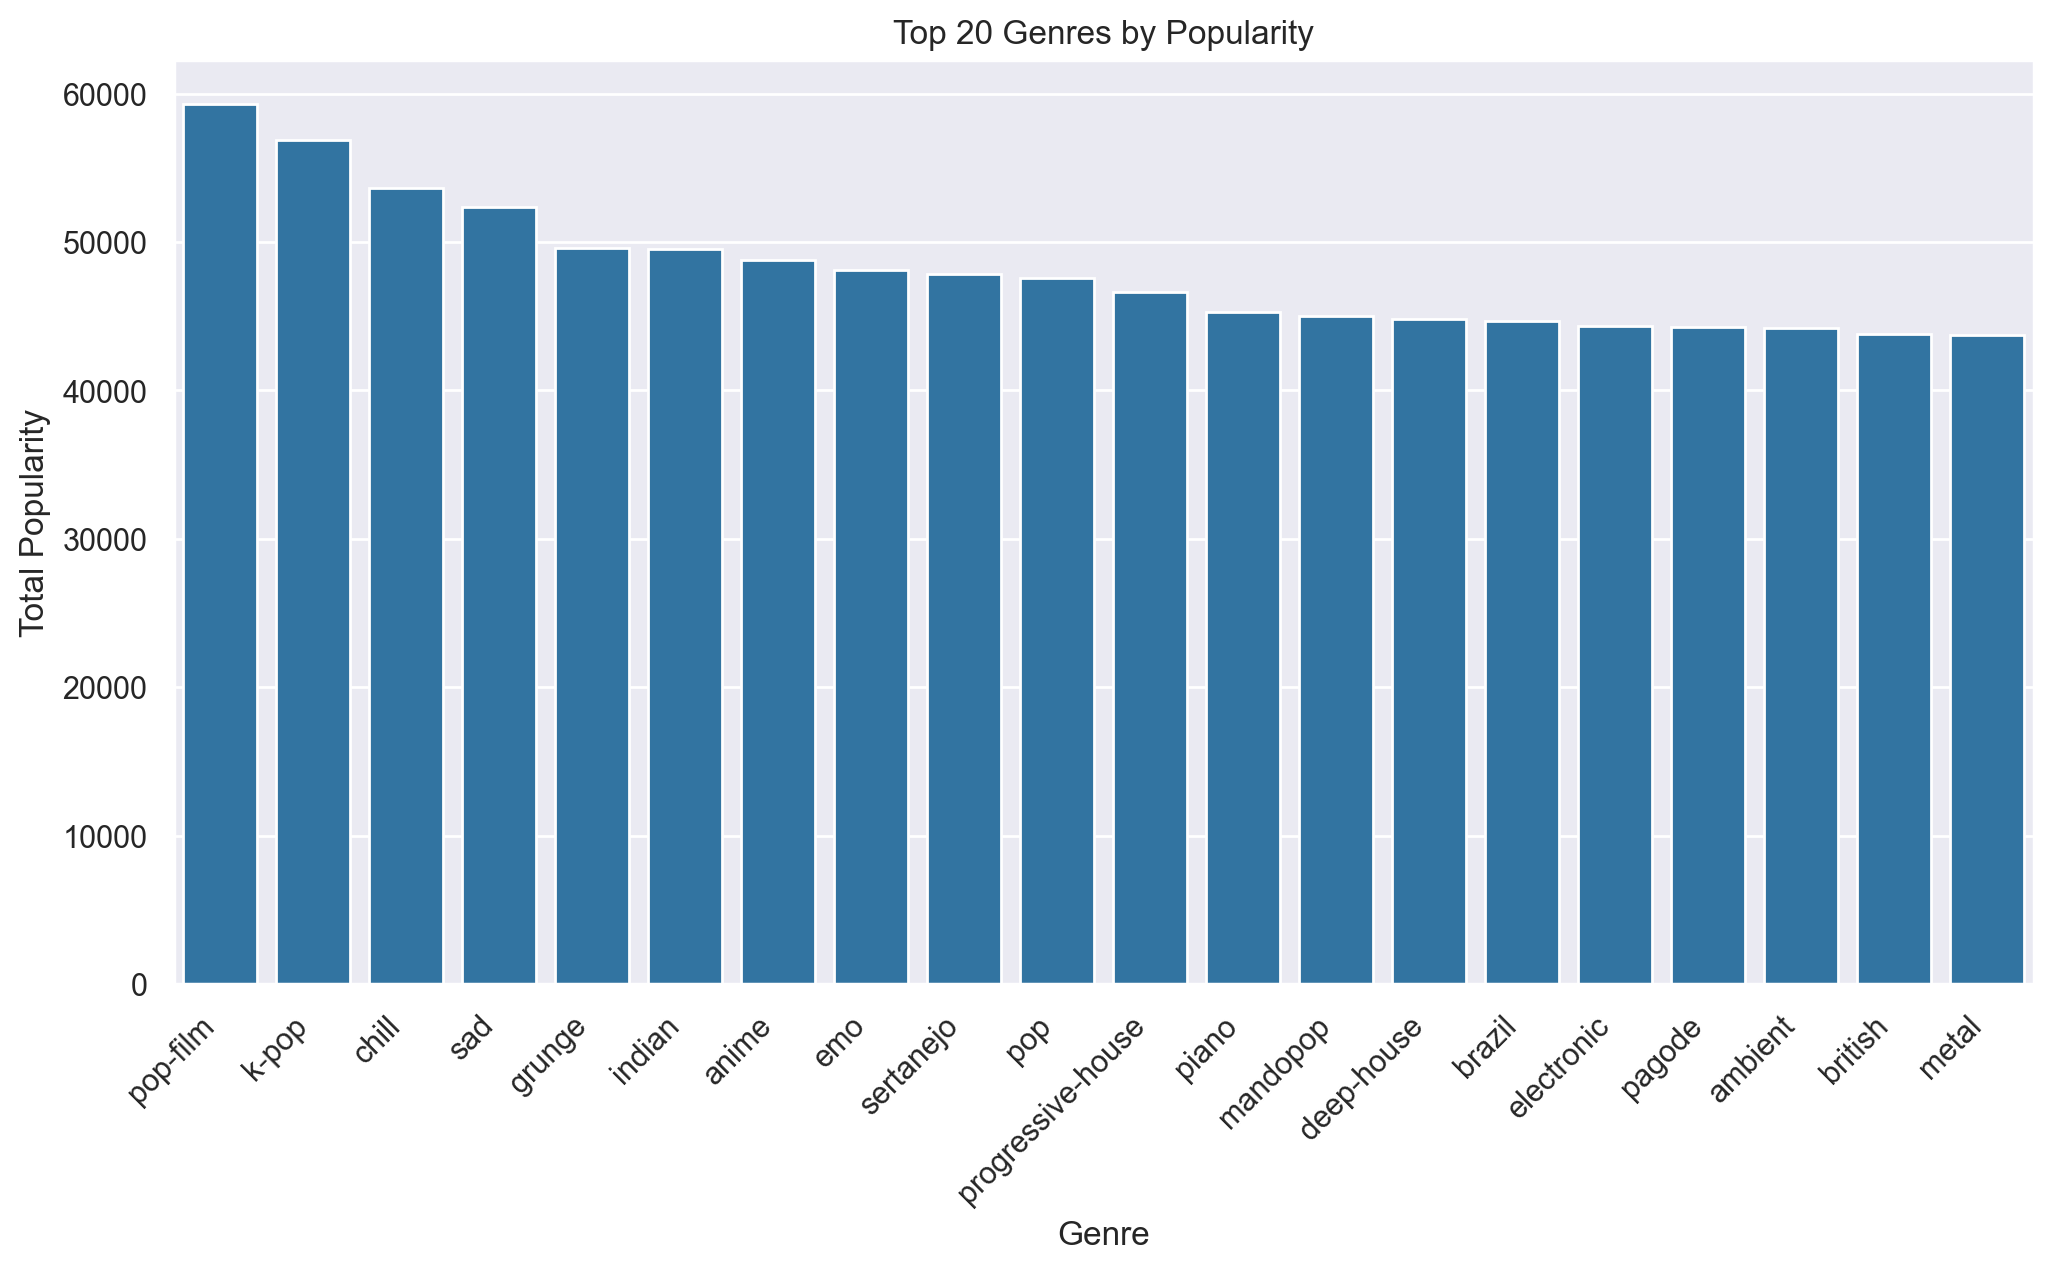

In [22]:
# Group by genre and sum popularity
genre_popularity = spotify_original.groupby('track_genre')['popularity'].sum().sort_values(ascending=False)

# Get the top 20 genres
top_20_genres = genre_popularity.head(20)

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_genres.index, y=top_20_genres.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Genre")
plt.ylabel("Total Popularity")
plt.title("Top 20 Genres by Popularity")
plt.show()

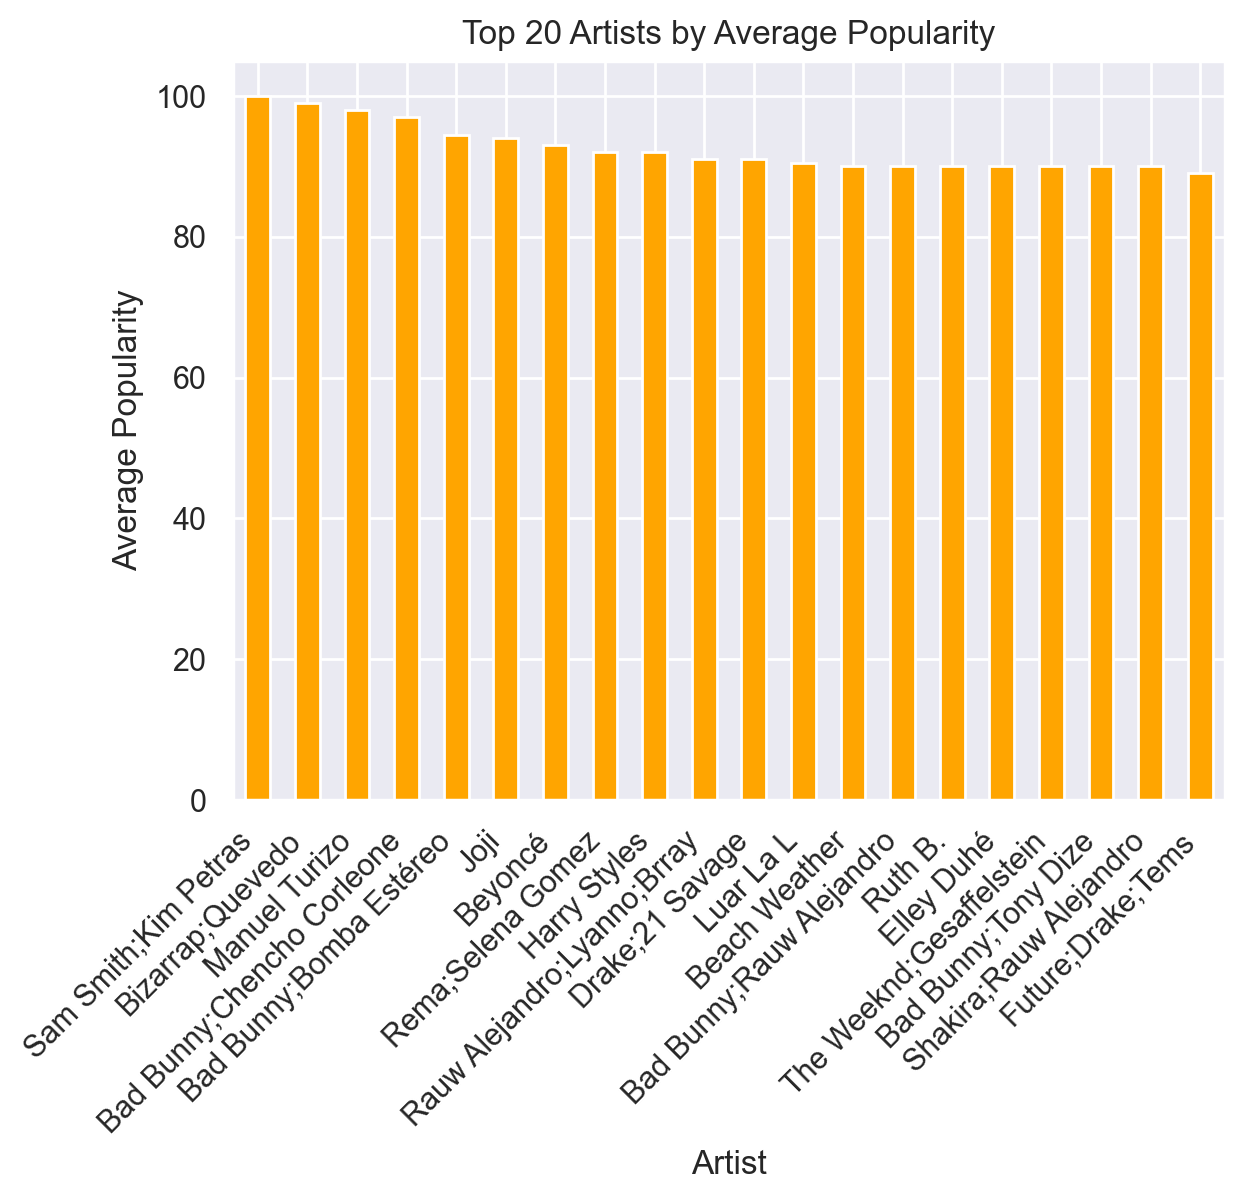

In [23]:
artist_popularity = spotify_original.groupby('artists')['popularity'].mean().sort_values(ascending=False)
artist_popularity.head(20).plot(kind='bar', color='orange')
plt.title('Top 20 Artists by Average Popularity')
plt.xlabel('Artist')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45, ha="right")
plt.show()


Let's see if, on average, explicit songs are more popular

C:\Users\Asus\AppData\Local\Temp\ipykernel_11744\3536452351.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




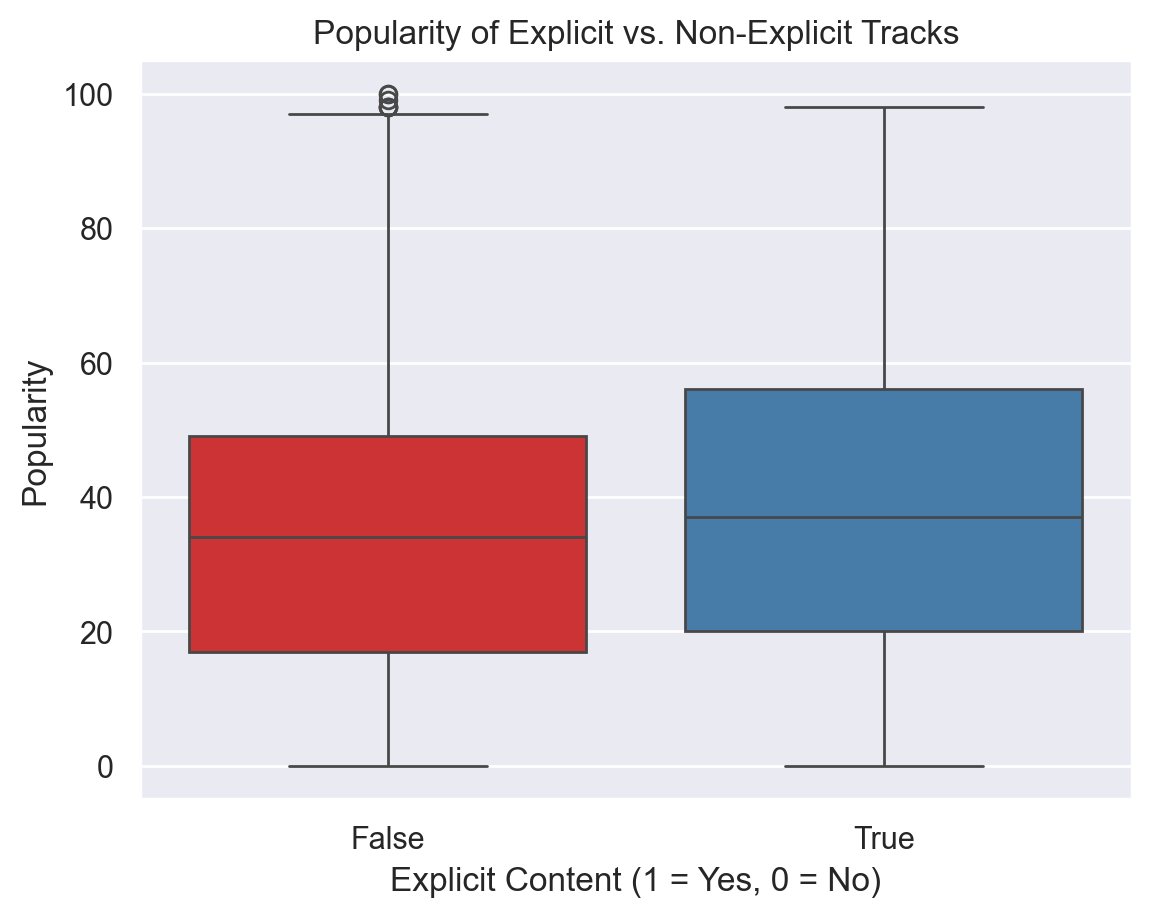

In [24]:
sns.boxplot(x='explicit', y='popularity', data=spotify_original, palette='Set1')
plt.title('Popularity of Explicit vs. Non-Explicit Tracks')
plt.xlabel('Explicit Content (1 = Yes, 0 = No)')
plt.ylabel('Popularity')
plt.show()


Let's plot the correlation Matrix.

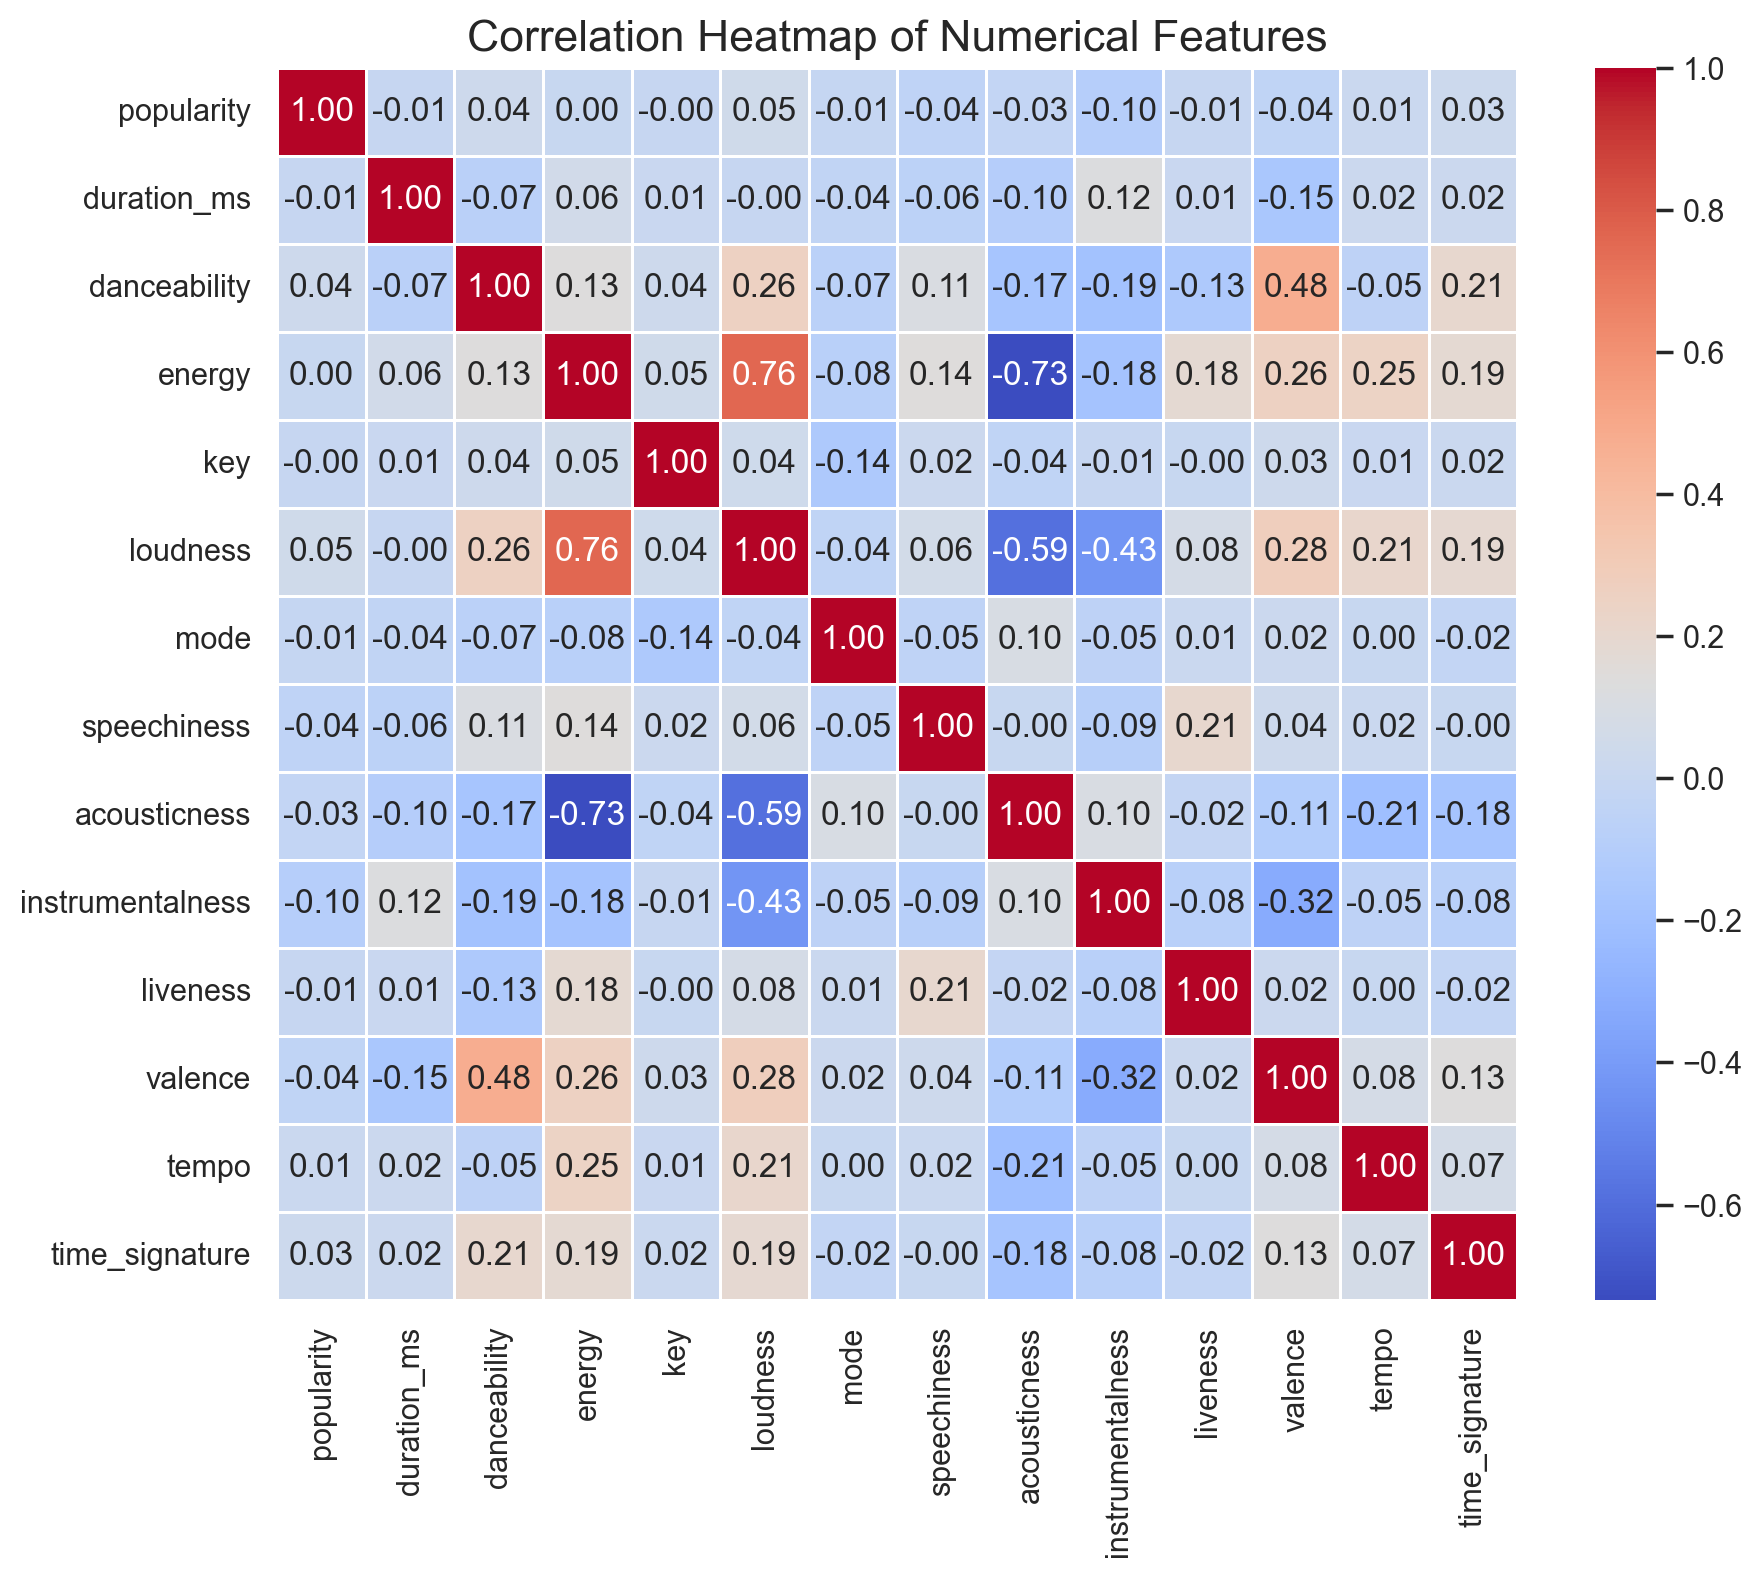

In [25]:
#numerical columns
numeric_columns = spotify_original.select_dtypes(include='number').columns

# Compute the correlation matrix for numerical columns
correlation_matrix = spotify_original[numeric_columns].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

### Correlations and Implications for Modeling

Upon analyzing the dataset, we observe that the correlations between the **popularity** feature and other features are quite weak. This poses a challenge if we decide to simulate popularity using a **regression algorithm**, as the model may struggle to capture meaningful relationships.

However, there are features that show **strong correlations** with each other. These include:
- **Energy**
- **Acousticness**(negatively correlated)
- **Loudness**

or
- **valence**
- **danceability**

This strong correlation arises from the way Spotify attributes scores to its tracks. For example, if a song is flagged as **energetic**, it is more likely to have a higher **loudness** as well, creating a pattern of dependency between these features.


Let's plot some more graphs to see if we can determinate informations.

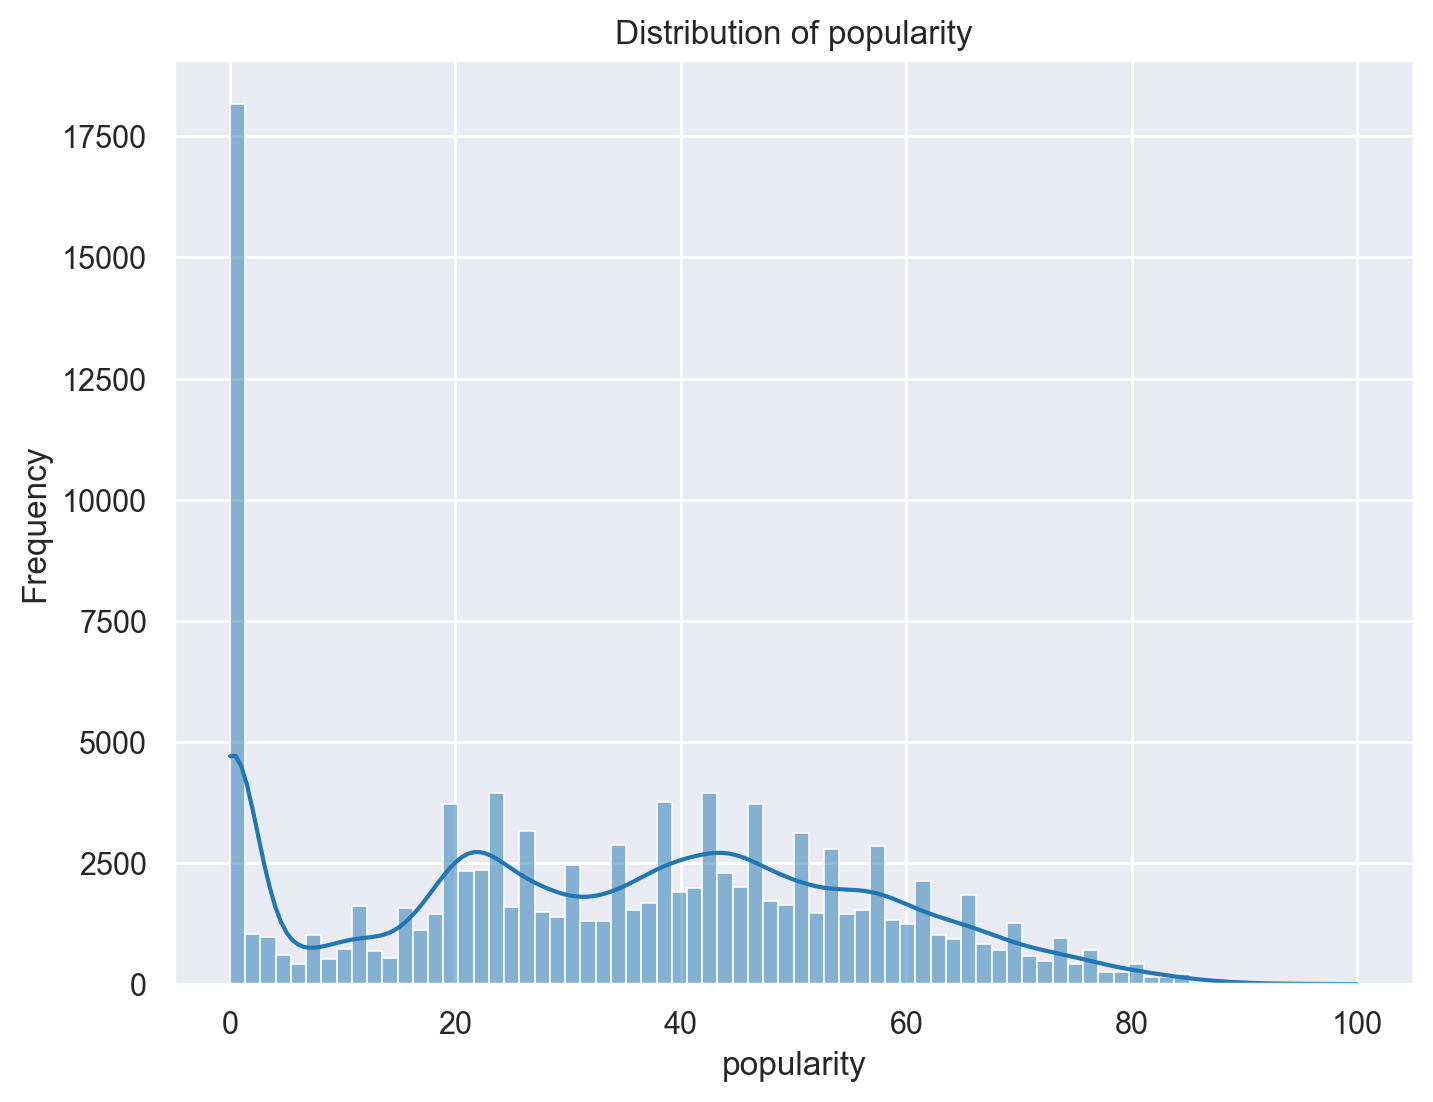

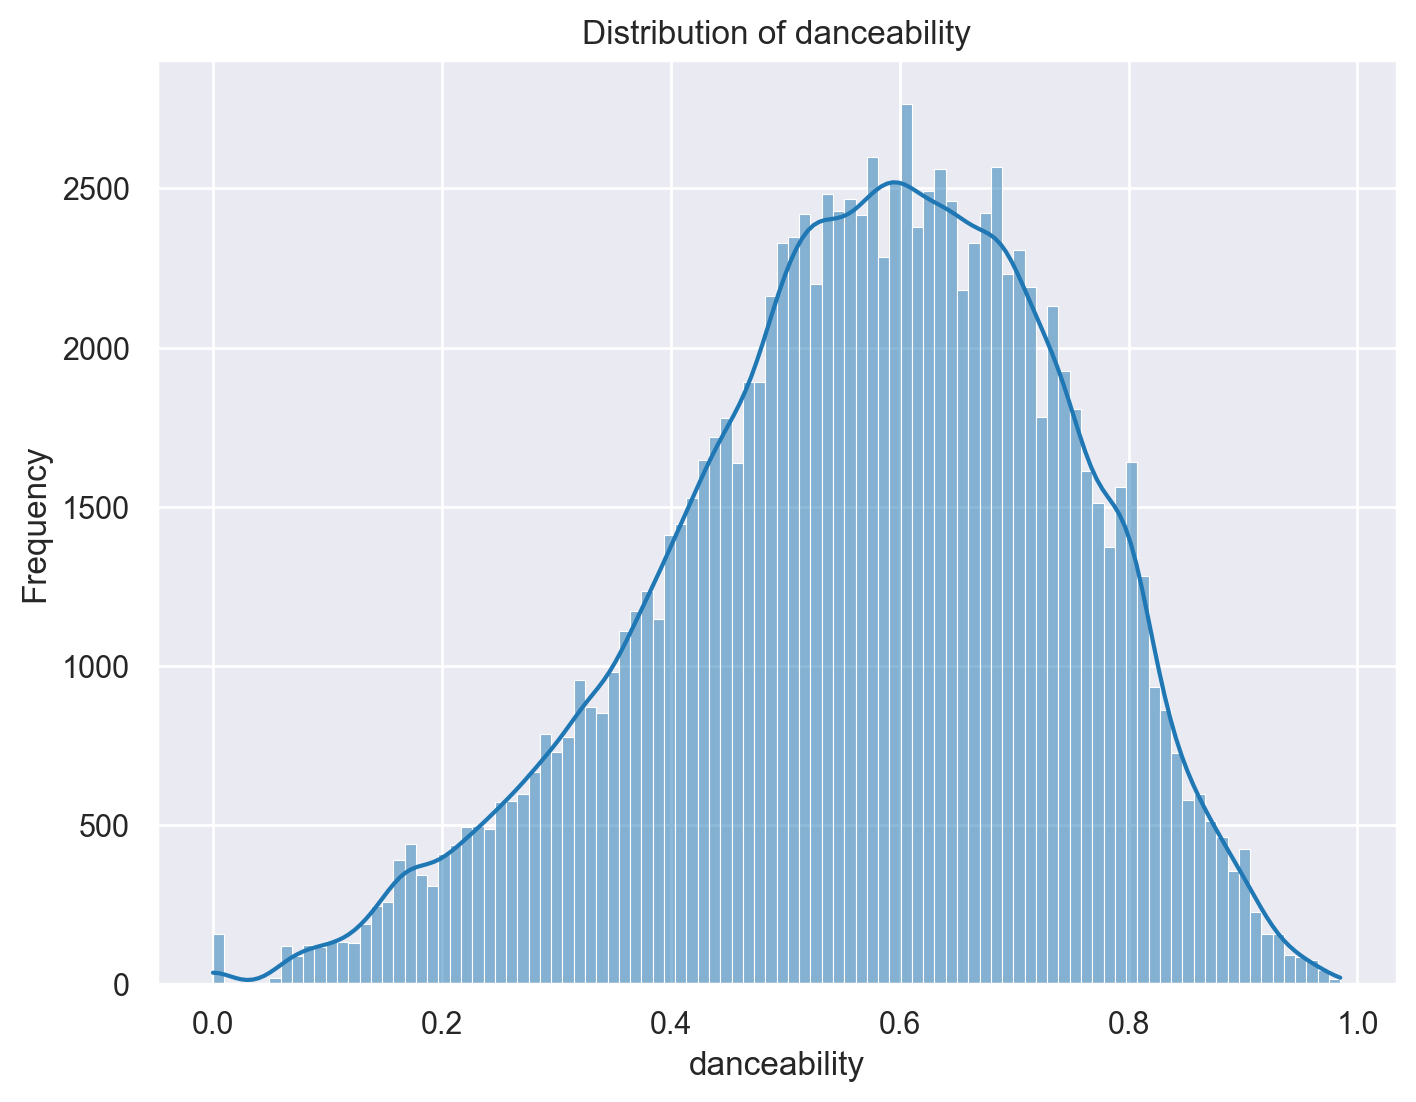

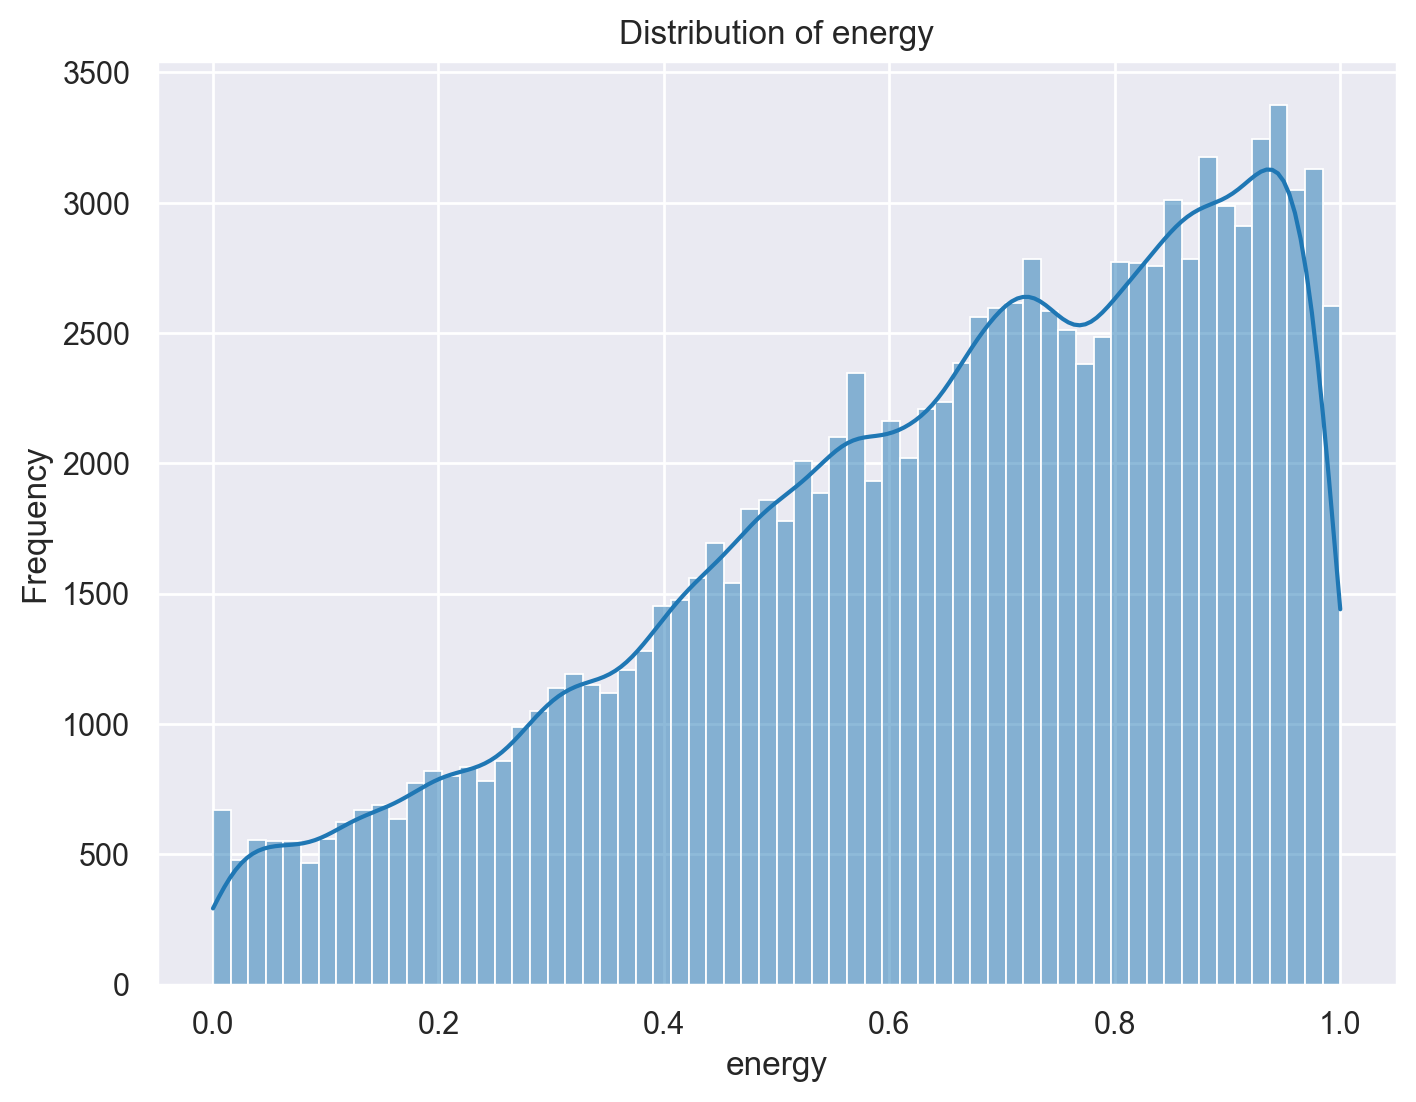

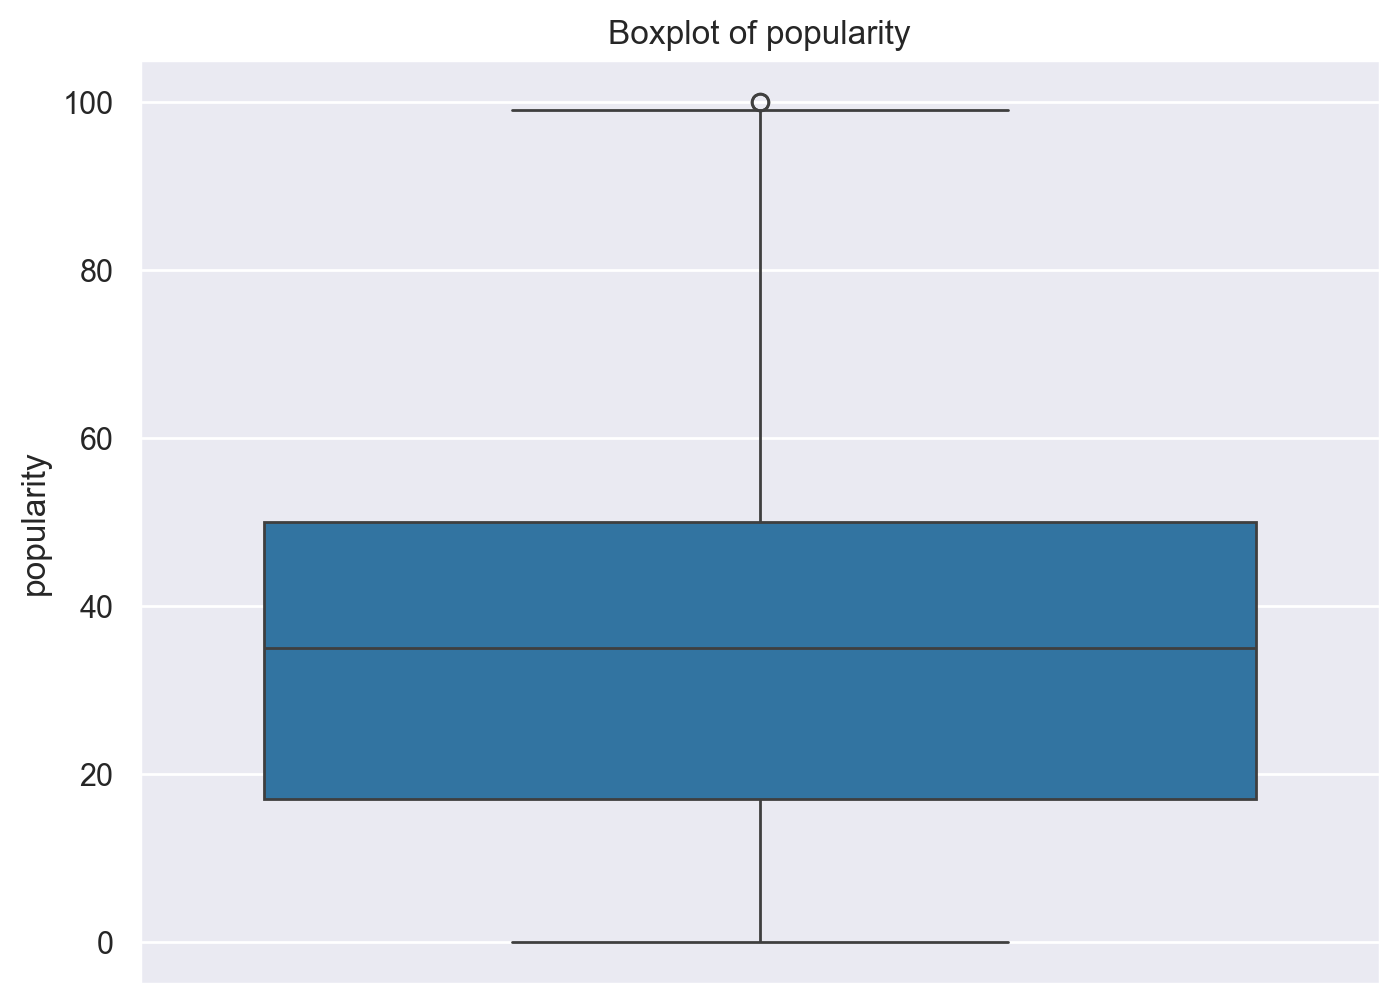

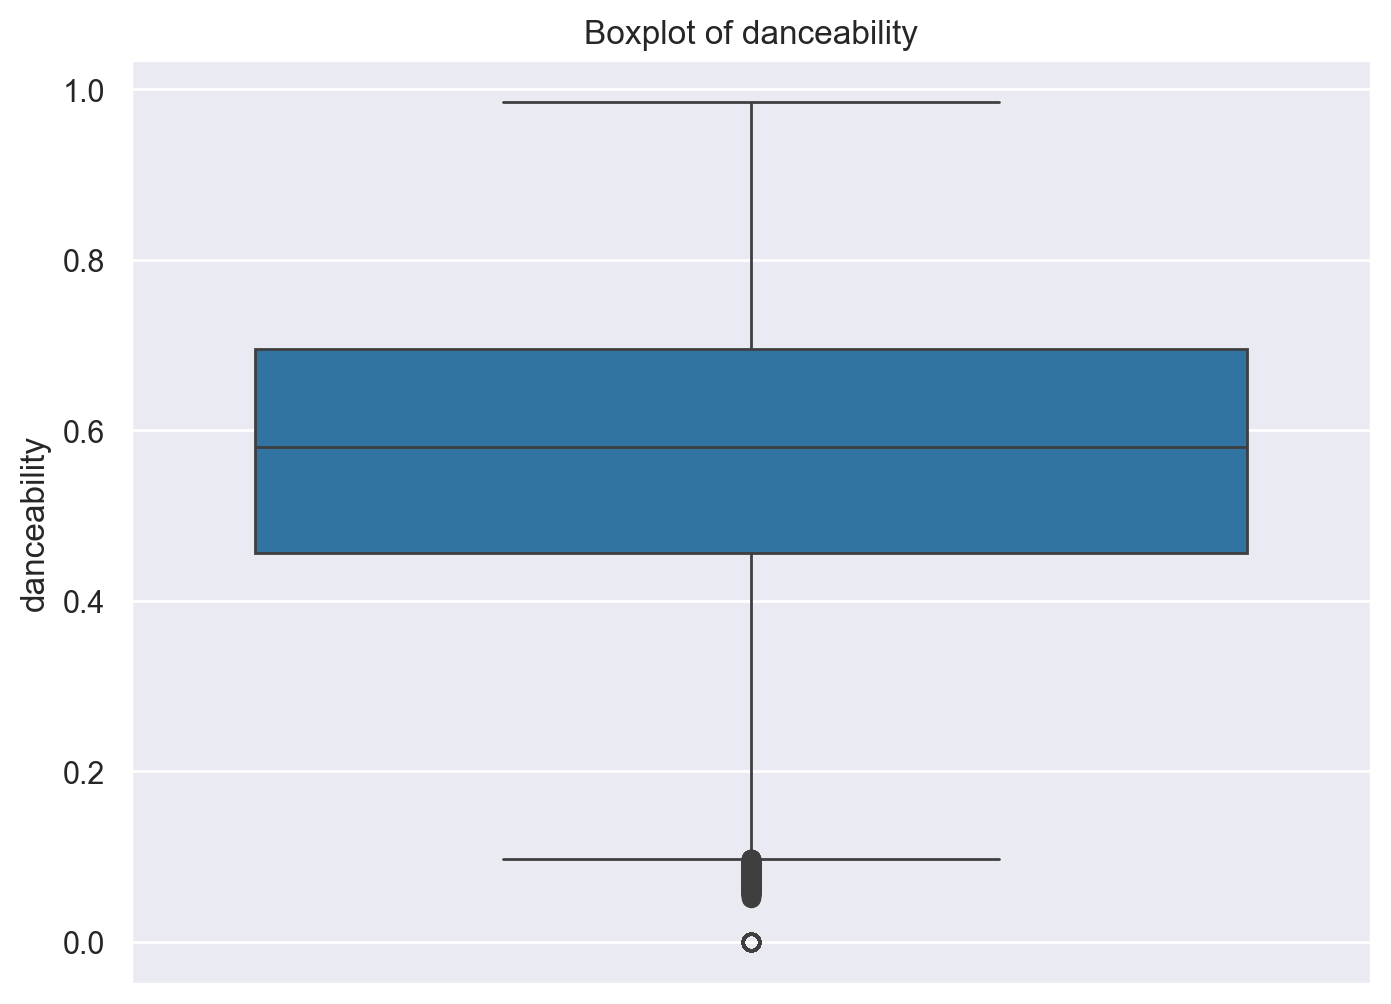

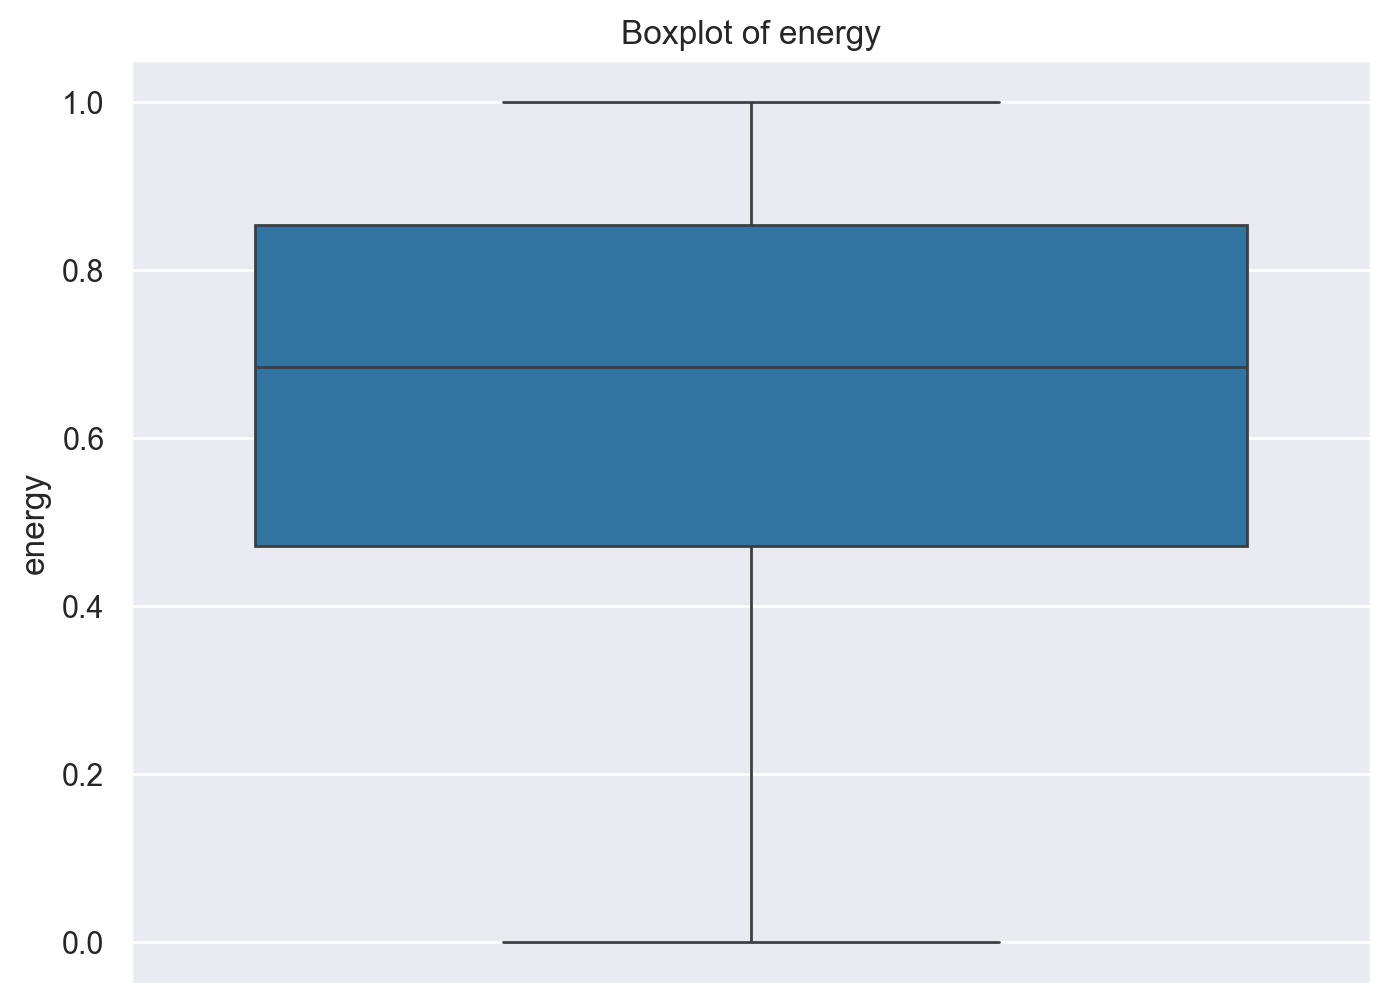

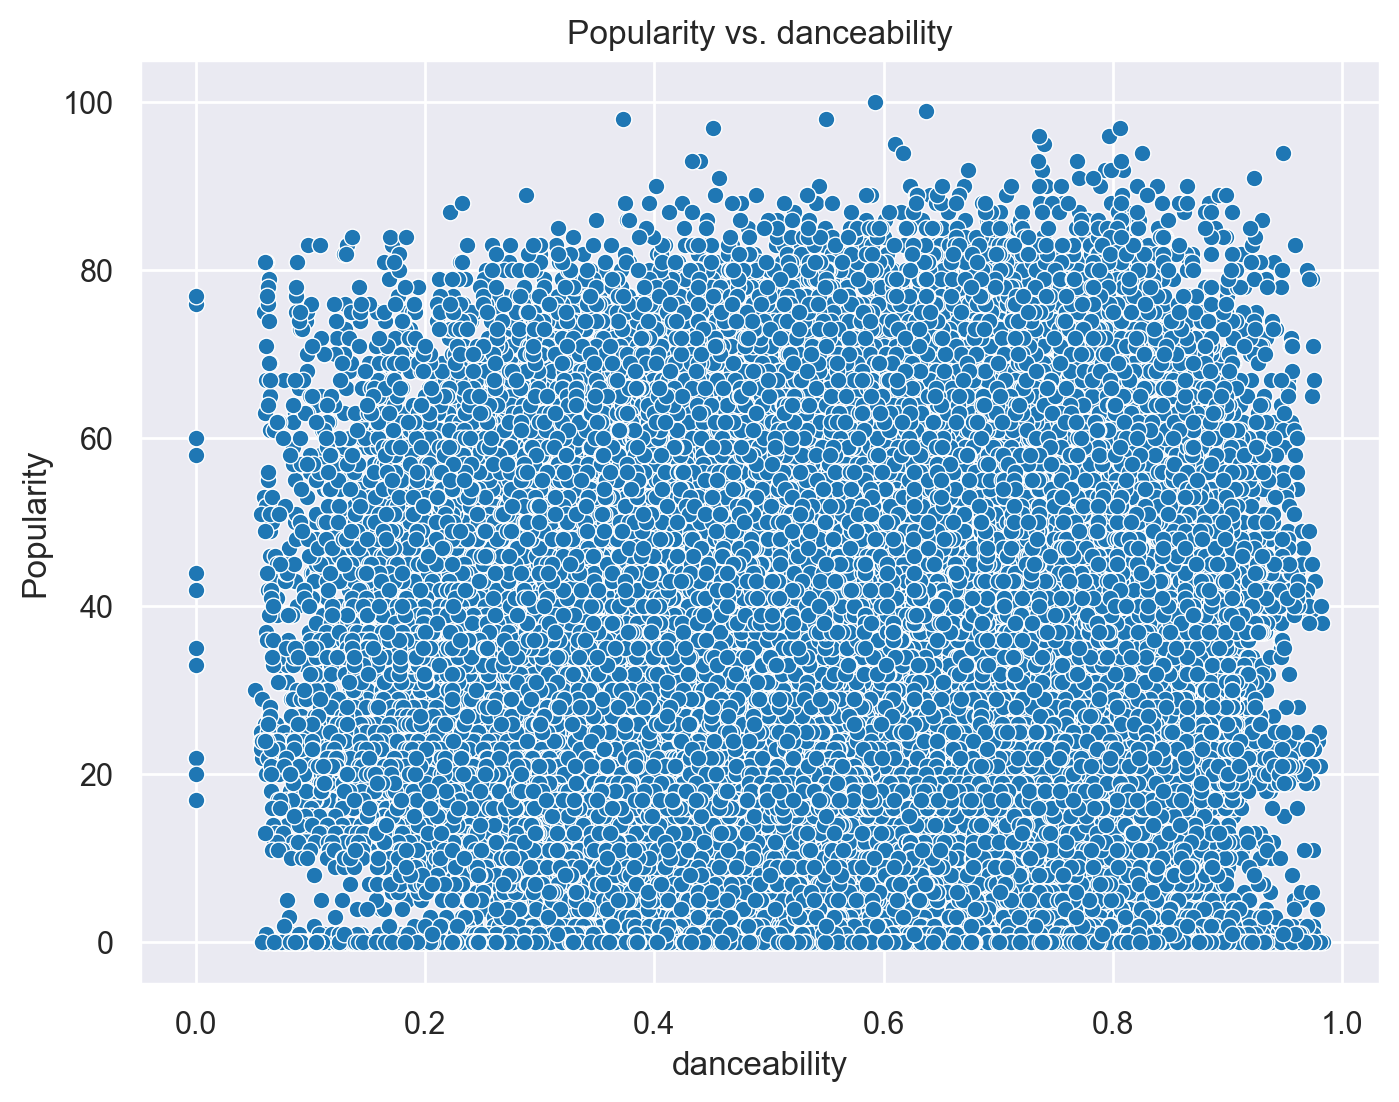

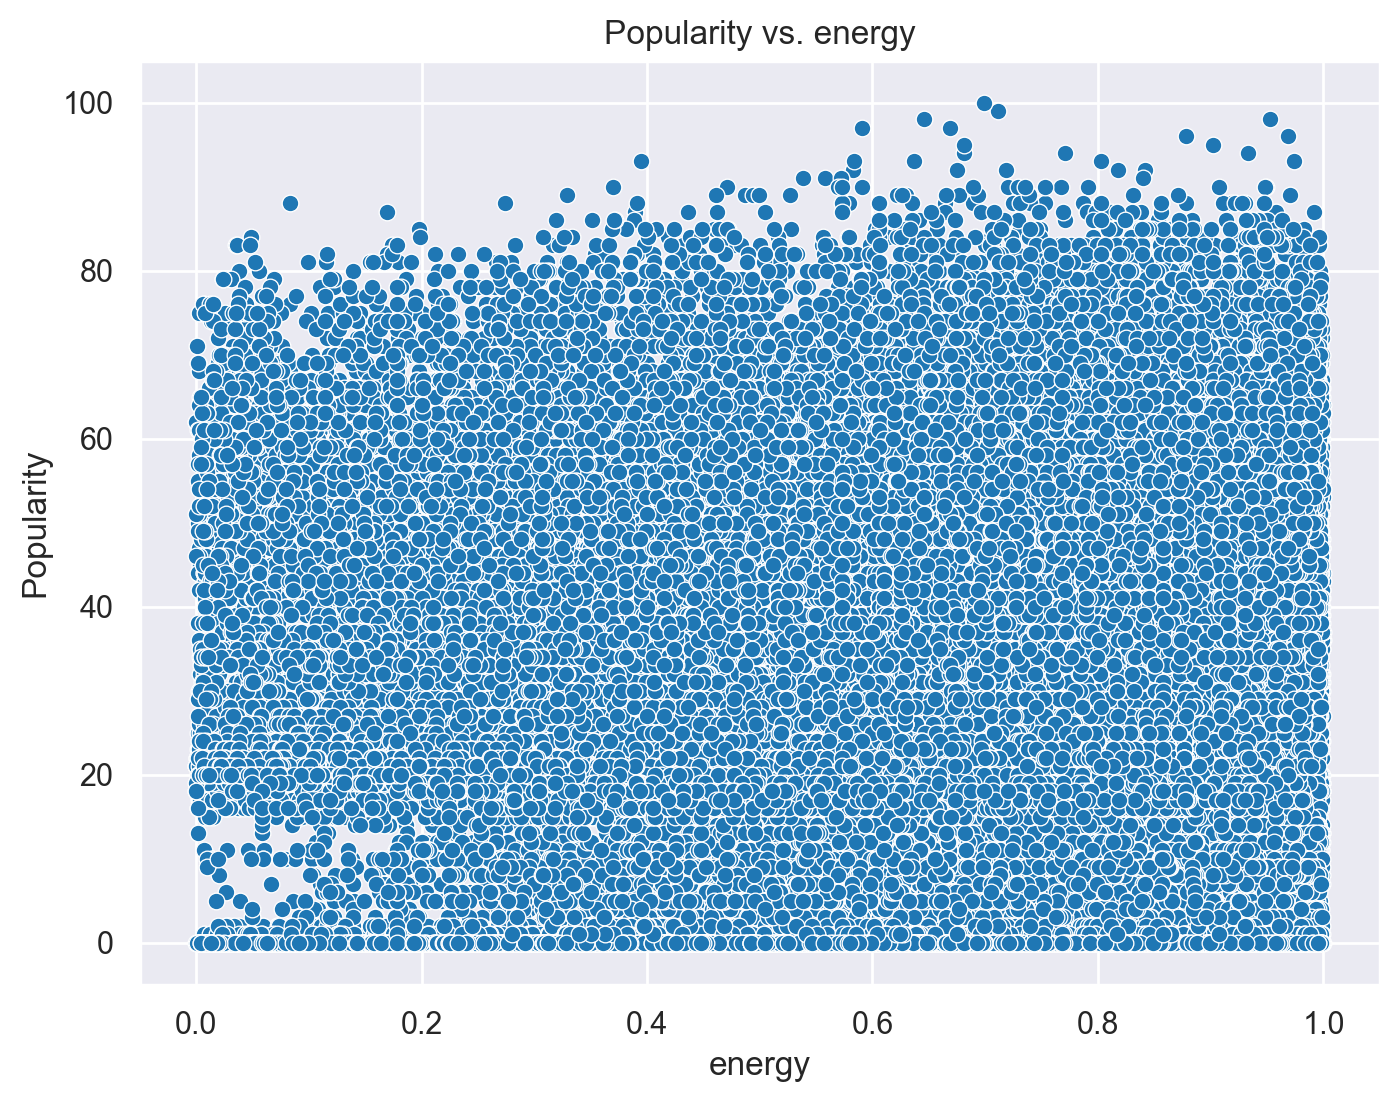

In [26]:

selected_features = ['popularity', 'danceability', 'energy']


# Distribution 
for col in selected_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(spotify_original[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Boxplots
for col in selected_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=spotify_original[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()

# relationship between 'popularity' and other features
for col in selected_features:
    if col != 'popularity':
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=spotify_original[col], y=spotify_df['popularity'])
        plt.title(f'Popularity vs. {col}')
        plt.xlabel(col)
        plt.ylabel('Popularity')
        plt.show()

### Distribution of Popularity Feature

Upon examining the distribution of the **popularity** feature, we observe that it is heavily skewed towards the tail. This indicates that the dataset is predominantly composed of **very unpopular songs**, which is expected, as most songs typically do not achieve high popularity.

### Implications for Modeling

Aside from this skew, no particular regularity or pattern emerges from the data. This further confirms that a **regression model** may not be well-suited for this problem, as the relationship between features and popularity does not appear to follow any trend.


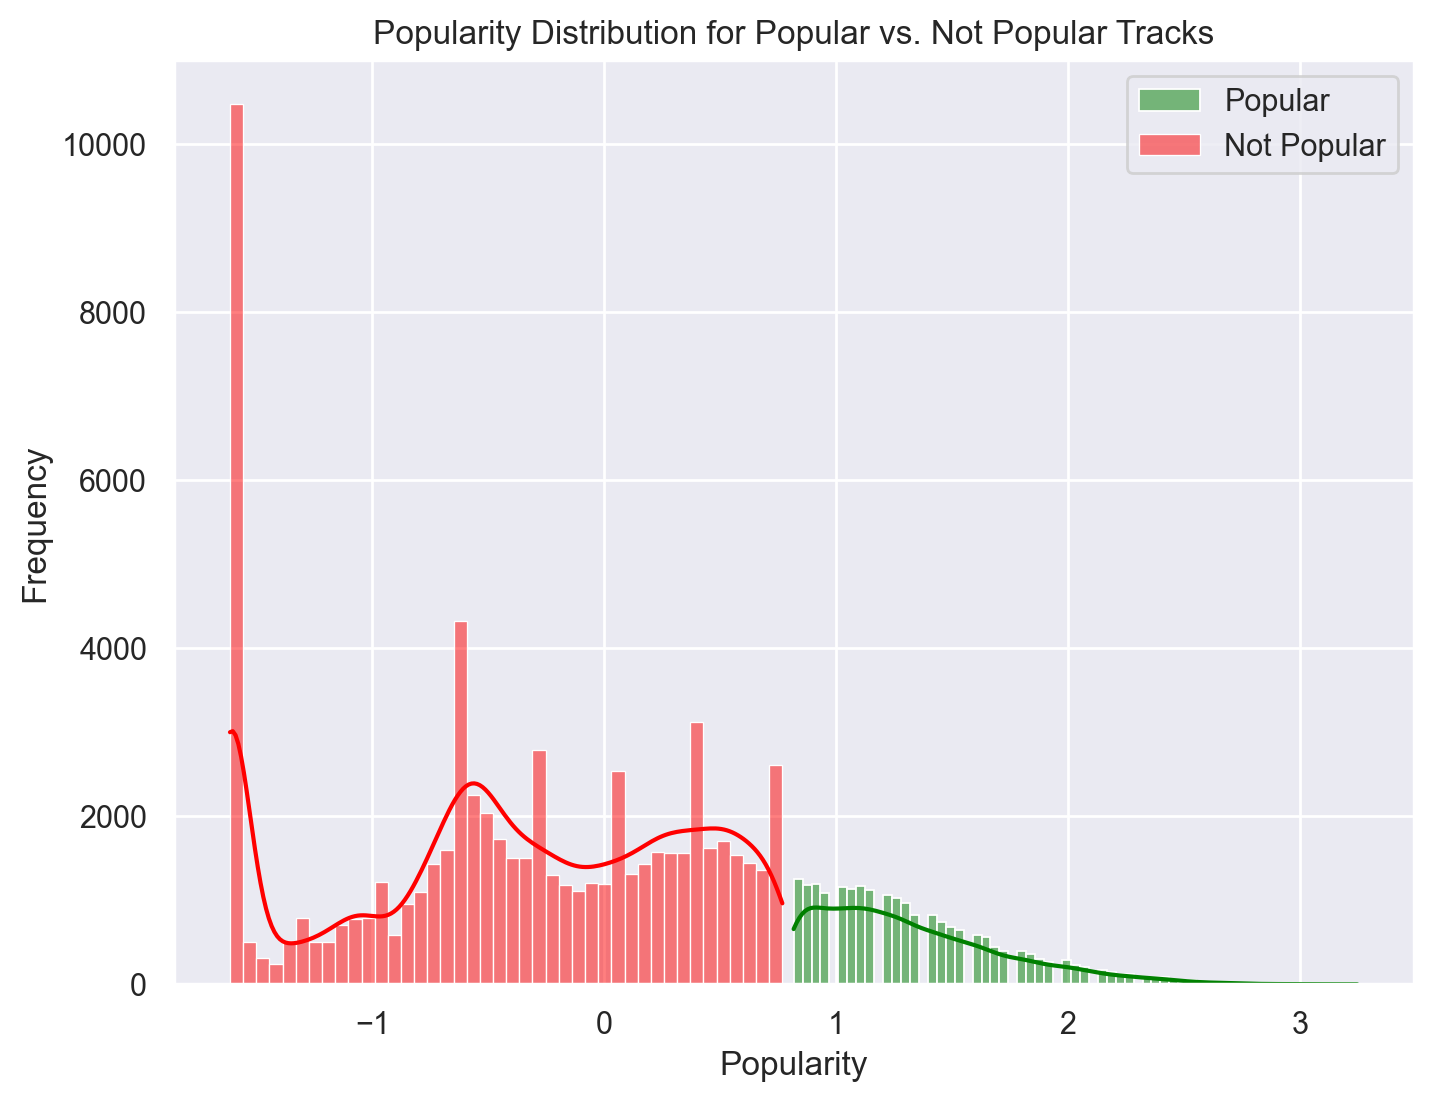

In [27]:
# histogram of the popular class (flagged 1) and the non popular class (flagged 0)
plt.figure(figsize=(8, 6))
sns.histplot(scaled_df[scaled_df["popularity_flag"] == 1]["popularity"], kde=True, label="Popular", color="green")
sns.histplot(scaled_df[scaled_df["popularity_flag"] == 0]["popularity"], kde=True, label="Not Popular", color="red")
plt.title("Popularity Distribution for Popular vs. Not Popular Tracks")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


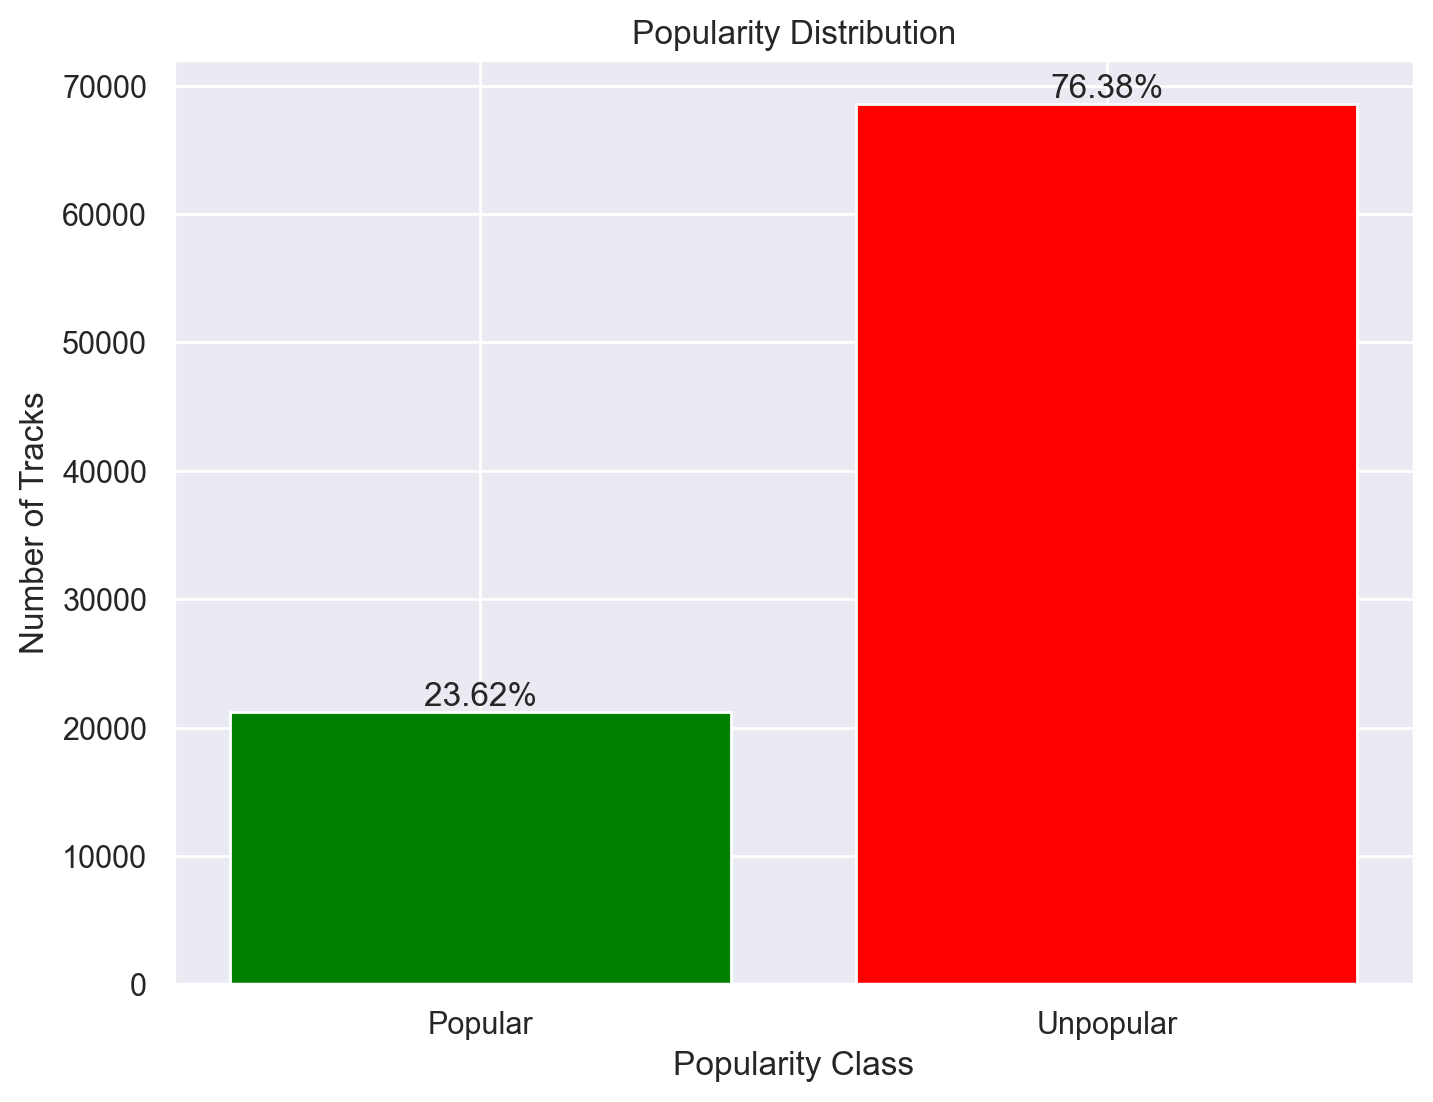

Proportion of Popular Tracks: 23.62%
Proportion of Unpopular Tracks: 76.38%


In [28]:
#popular and unpopular count
popular_count = scaled_df[scaled_df["popularity_flag"] == 1].shape[0]
unpopular_count = scaled_df[scaled_df["popularity_flag"] == 0].shape[0]

total_count = popular_count + unpopular_count
popular_proportion = popular_count / total_count
unpopular_proportion = unpopular_count / total_count

plt.figure(figsize=(8, 6))
plt.bar(["Popular", "Unpopular"], [popular_count, unpopular_count], color=["green", "red"])
plt.xlabel("Popularity Class")
plt.ylabel("Number of Tracks")
plt.title("Popularity Distribution")

# Add proportions as text annotations
plt.text(0, popular_count, f"{popular_proportion:.2%}", ha="center", va="bottom")
plt.text(1, unpopular_count, f"{unpopular_proportion:.2%}", ha="center", va="bottom")

plt.show()

print(f"Proportion of Popular Tracks: {popular_proportion:.2%}")
print(f"Proportion of Unpopular Tracks: {unpopular_proportion:.2%}")

## Class Imbalance

The analysis reveals a significant class imbalance in the 'popularity_flag' target variable.  This imbalance (approximately 78% unpopular vs. 22% popular) can lead to biased model training, where the model might become overly proficient at predicting the majority class (unpopular) while performing poorly on the minority class (popular).

To address this, we have many primary options:

1. **Resampling:** We can use resampling techniques to balance the class distribution.  This could involve either oversampling the minority class (popular songs) or undersampling the majority class (unpopular songs).

2. **Changing the popularity threshold** to correct the imbalance.

2. **Weighted F1-Score:** Due to the inherent bias in the dataset, using the standard accuracy metric might be misleading.  Instead, we can utilize a weighted F1-score.  The weighted F1-score gives more importance to the minority class, providing a more balanced evaluation of the model's performance across all classes.  By using a weighted metric, we can better assess the model's ability to correctly classify popular tracks, which are crucial for the intended use case.

3. The **Macro F1 score** evaluates the performance of a classification model by calculating the F1 score for each class individually and then averaging them. Unlike the weighted F1 score, the Macro F1 score treats all classes equally, regardless of their size or prevalence in the dataset.
This metric is especially useful for:
   - Assessing model performance on imbalanced datasets.
   - Ensuring that minority and majority classes are given equal importance.
  
  A high Macro F1 score indicates balanced performance across all classes, while a low score highlights poor performance on one or more classes.

Let's set the threshold at 40%.

In [29]:
spotify_df["popularity_flag"] = 0
spotify_df.loc[spotify_df["popularity"] >= 40, "popularity_flag"] = 1
spotify_df.info()
spotify_df

# we use standard scaler
stdscaler = preprocessing.StandardScaler()
y_target = spotify_df["popularity_flag"]
qualitative_df = spotify_df[col_qualitative]
qualitative_df['popularity_flag'] = y_target

quantitative_df = spotify_df.drop(columns=col_qualitative)
quantitative_df.drop(columns="popularity_flag", inplace=True)

scaled_df = pd.DataFrame(stdscaler.fit_transform(quantitative_df), columns=quantitative_df.columns, index=quantitative_df.index)
scaled_df = pd.concat([scaled_df, qualitative_df], axis=1)

scaled_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89740 entries, 0 to 89739
Columns: 145 entries, popularity to popularity_flag
dtypes: float64(9), int64(136)
memory usage: 99.3 MB


C:\Users\Asus\AppData\Local\Temp\ipykernel_11744\1607833152.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



popularity   duration_ms      explicit  danceability        energy  \
count  8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04   
mean  -2.533694e-18 -7.601081e-17 -7.221027e-17  5.308088e-16 -8.867928e-18   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -1.614106e+00 -1.952792e+00 -3.064474e-01 -3.181635e+00 -2.472511e+00   
25%   -6.904461e-01 -4.967399e-01 -3.064474e-01 -6.348163e-01 -6.915629e-01   
50%   -9.854376e-03 -1.403236e-01 -3.064474e-01  7.829285e-02  1.618890e-01   
75%    7.679647e-01  3.112009e-01 -3.064474e-01  7.348060e-01  8.516653e-01   
max    3.247263e+00  4.434144e+01  3.263203e+00  2.393068e+00  1.424530e+00   

           loudness          mode   speechiness  acousticness  \
count  8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04   
mean   2.128303e-16 -1.773586e-17 -2.153640e-16  1.621564e-16   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -7.858297e+00 -1.324621e+00 -7.719334e-01 -9.703424e-01   
25%   -3.491832e-01 -1.324621e+00 -4.541285e-01 -9.197984e-01   
50%    2.516512e-01  7.549332e-01 -3.402484e-01 -4.146533e-01   
75%    6.494305e-01  7.549332e-01 -1.361559e-02  8.770282e-01   
max    2.495647e+00  7.549332e-01  7.747003e+00  1.973627e+00   

       instrumentalness      liveness       valence         tempo  \
count      8.974000e+04  8.974000e+04  8.974000e+04  8.974000e+04   
mean      -1.520216e-16 -2.407009e-17  1.824259e-16  7.977968e-16   
std        1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min       -5.354847e-01 -1.113336e+00 -1.786011e+00 -4.052734e+00   
25%       -5.354847e-01 -6.094458e-01 -8.387457e-01 -7.568821e-01   
50%       -5.353056e-01 -4.360091e-01 -4.745621e-02 -1.498606e-03   
75%       -2.340311e-01  3.182866e-01  8.085060e-01  5.982859e-01   
max        2.552389e+00  4.017927e+00  1.999245e+00  4.028021e+00   

       track_genre_new-age  track_genre_k-pop  track_genre_r-n-b  \
count         89740.000000       89740.000000       89740.000000   
mean              0.011076           0.011121           0.011143   
std               0.104661           0.104869           0.104973   
min               0.000000           0.000000           0.000000   
25%               0.000000           0.000000           0.000000   
50%               0.000000           0.000000           0.000000   
75%               0.000000           0.000000           0.000000   
max               1.000000           1.000000           1.000000   

       track_genre_british  track_genre_cantopop  track_genre_opera  \
count         89740.000000          89740.000000       89740.000000   
mean              0.011143              0.011132           0.011054   
std               0.104973              0.104921           0.104557   
min               0.000000              0.000000           0.000000   
25%               0.000000              0.000000           0.000000   
50%               0.000000              0.000000           0.000000   
75%               0.000000              0.000000           0.000000   
max               1.000000              1.000000           1.000000   

       track_genre_forro  track_genre_swedish  track_genre_detroit-techno  \
count       89740.000000         89740.000000                89740.000000   
mean            0.011121             0.011143                    0.011121   
std             0.104869             0.104973                    0.104869   
min             0.000000             0.000000                    0.000000   
25%             0.000000             0.000000                    0.000000   
50%             0.000000             0.000000                    0.000000   
75%             0.000000             0.000000                    0.000000   
max             1.000000             1.000000                    1.000000   

       track_genre_show-tunes  track_genre_pop  track_genre_hard-rock  \
count            89740.000000     89740.000000           89740.000000

In [30]:
minmaxscaler = preprocessing.MinMaxScaler()
y_target = spotify_df["popularity_flag"]


minmax_df = pd.DataFrame(minmaxscaler.fit_transform(spotify_df), columns=spotify_df.columns, index=spotify_df.index)

minmax_df.describe()


popularity   duration_ms      explicit  danceability        energy  \
count  89740.000000  89740.000000  89740.000000  89740.000000  89740.000000   
mean       0.332027      0.042182      0.085848      0.570727      0.634458   
std        0.205704      0.021601      0.280141      0.179383      0.256606   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.190000      0.031452      0.000000      0.456853      0.457000   
50%        0.330000      0.039151      0.000000      0.584772      0.676000   
75%        0.490000      0.048904      0.000000      0.702538      0.853000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           loudness          mode   speechiness  acousticness  \
count  89740.000000  89740.000000  89740.000000  89740.000000   
mean       0.758967      0.636973      0.090614      0.329603   
std        0.096582      0.480875      0.117386      0.339679   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.725242      0.000000      0.037306      0.017169   
50%        0.783271      1.000000      0.050674      0.188755   
75%        0.821690      1.000000      0.089016      0.627510   
max        1.000000      1.000000      1.000000      1.000000   

       instrumentalness      liveness       valence         tempo  \
count      89740.000000  89740.000000  89740.000000  89740.000000   
mean           0.173415      0.216971      0.471834      0.501529   
std            0.323849      0.194885      0.264184      0.123752   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.098200      0.250251      0.407864   
50%            0.000058      0.132000      0.459296      0.501344   
75%            0.097625      0.279000      0.685427      0.575567   
max            1.000000      1.000000      1.000000      1.000000   

              key_0         key_1         key_2         key_3         key_4  \
count  89740.000000  89740.000000  89740.000000  89740.000000  89740.000000   
mean       0.115355      0.095565      0.103934      0.030856      0.079485   
std        0.319452      0.293995      0.305176      0.172928      0.270496   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              key_5         key_6         key_7         key_8         key_9  \
count  89740.000000  89740.000000  89740.000000  89740.000000  89740.000000   
mean       0.081435      0.068409      0.117562      0.062068      0.100267   
std        0.273504      0.252447      0.322090      0.241281      0.300358   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             key_10        key_11  time_signature_0  time_signature_1  \
count  89740.000000  89740.000000      89740.000000      89740.000000   
mean       0.065623      0.079441          0.001805          0.009427   
std        0.247623      0.270427          0.042450          0.096636   
min        0.000000      0.000000          0.000000          0.000000   
25%        0.000000      0.000000          0.000000          0.000000   
50%        0.000000      0.000000          0.000000          0.000000   
75%        0.000000      0.000000          0.000000          0.000000   
max        1.000000      1.000000          1.000000          1.000000   

       

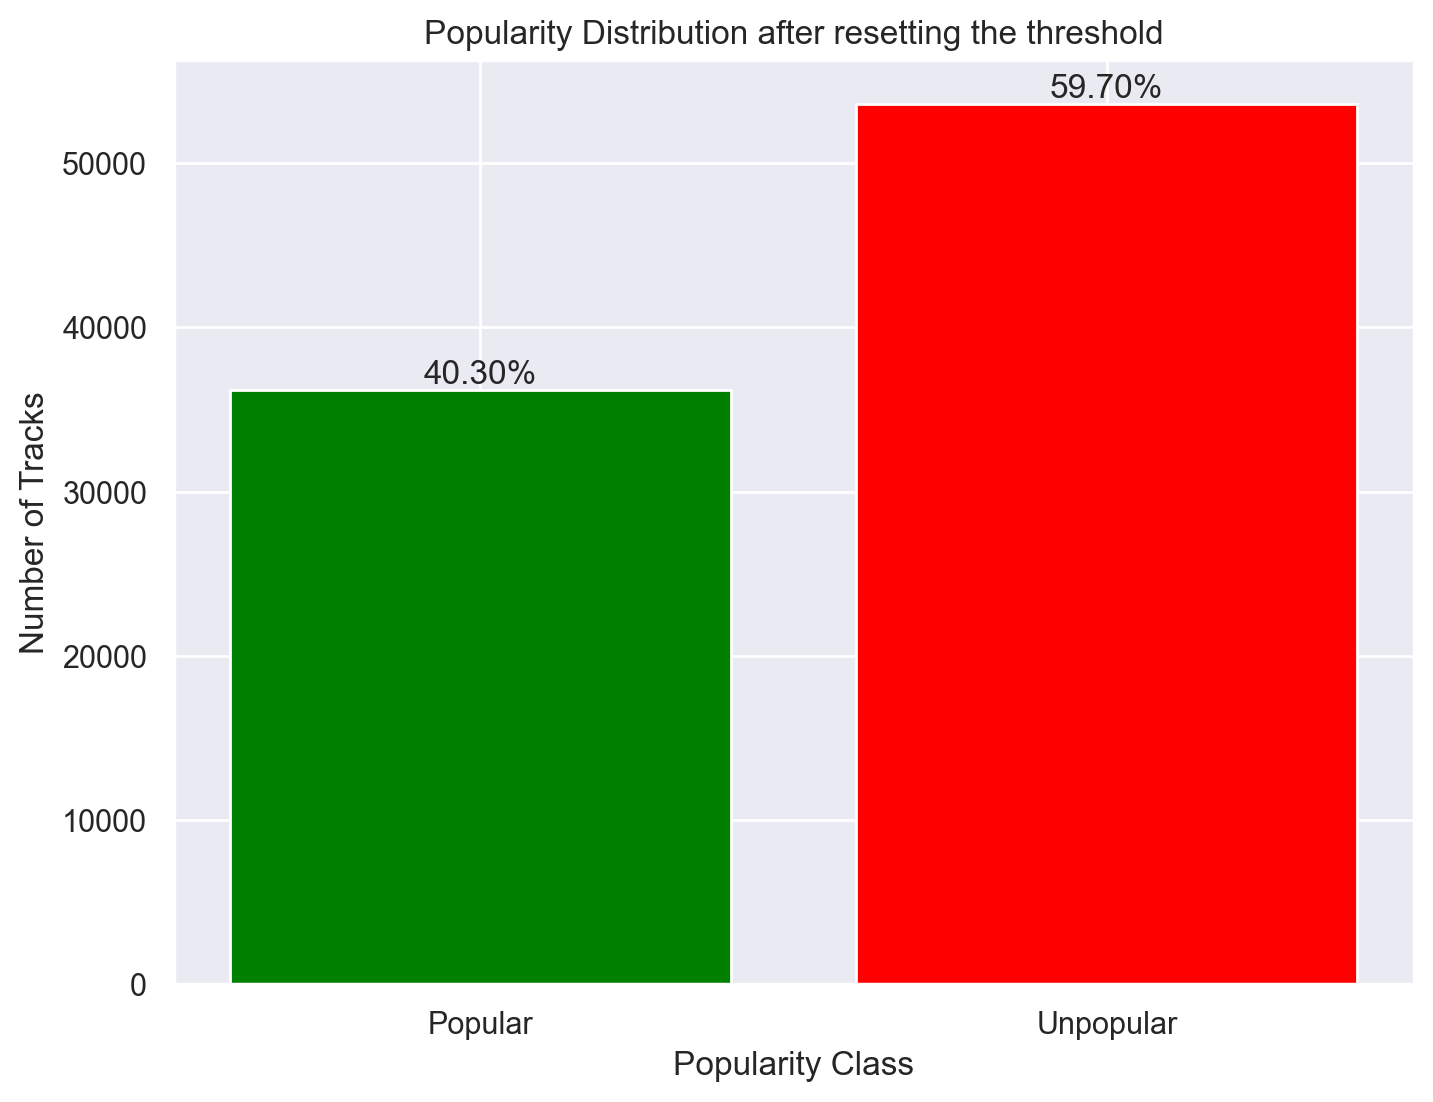

Proportion of Popular Tracks: 40.30%
Proportion of Unpopular Tracks: 59.70%


In [31]:

#popular and unpopular count
popular_count = scaled_df[scaled_df["popularity_flag"] == 1].shape[0]
unpopular_count = scaled_df[scaled_df["popularity_flag"] == 0].shape[0]

total_count = popular_count + unpopular_count
popular_proportion = popular_count / total_count
unpopular_proportion = unpopular_count / total_count

plt.figure(figsize=(8, 6))
plt.bar(["Popular", "Unpopular"], [popular_count, unpopular_count], color=["green", "red"])
plt.xlabel("Popularity Class")
plt.ylabel("Number of Tracks")
plt.title("Popularity Distribution after resetting the threshold")

# Add proportions as text annotations
plt.text(0, popular_count, f"{popular_proportion:.2%}", ha="center", va="bottom")
plt.text(1, unpopular_count, f"{unpopular_proportion:.2%}", ha="center", va="bottom")

plt.show()

print(f"Proportion of Popular Tracks: {popular_proportion:.2%}")
print(f"Proportion of Unpopular Tracks: {unpopular_proportion:.2%}")

Splitting the preprocessed dateset using `train_test_split()` function (80% train, 20% test)

In [32]:
threshold_scaled = np.percentile(scaled_df["popularity"], 1)

# Display the threshold corresponding to the 1% in the scaled data
print(f"Threshold for the lower 1% of popularity in scaled data: {threshold_scaled}")

Threshold for the lower 1% of popularity in scaled data: -1.614106319959939


In [33]:
X = scaled_df.drop(columns=["popularity_flag","popularity"])
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.2, random_state=42)


# **Resampling for Class Imbalance**



## **Resampling Method: Undersampling the Majority Class**
We apply **undersampling** to the majority class (songs with a low popularity index). The steps taken are as follows:

1. **Separate the Songs by Popularity**:
   - We split the dataset into two groups:
     - **Low popularity songs** (with a popularity index close to 0).
     - **High popularity songs** (with a higher popularity index).
   
2. **Undersample the Low Popularity Songs**:
   - We reduce the number of low popularity songs to a fixed amount.
   - This helps balance the dataset, preventing the model from being biased towards predicting the majority class (low popularity).

3. **Combine the Resampled Dataset**:
   - After undersampling, we combine the reduced low popularity group with the high popularity group, resulting in a more balanced dataset.

Low popularity songs count in training data: 7433
High popularity songs count in training data: 64359


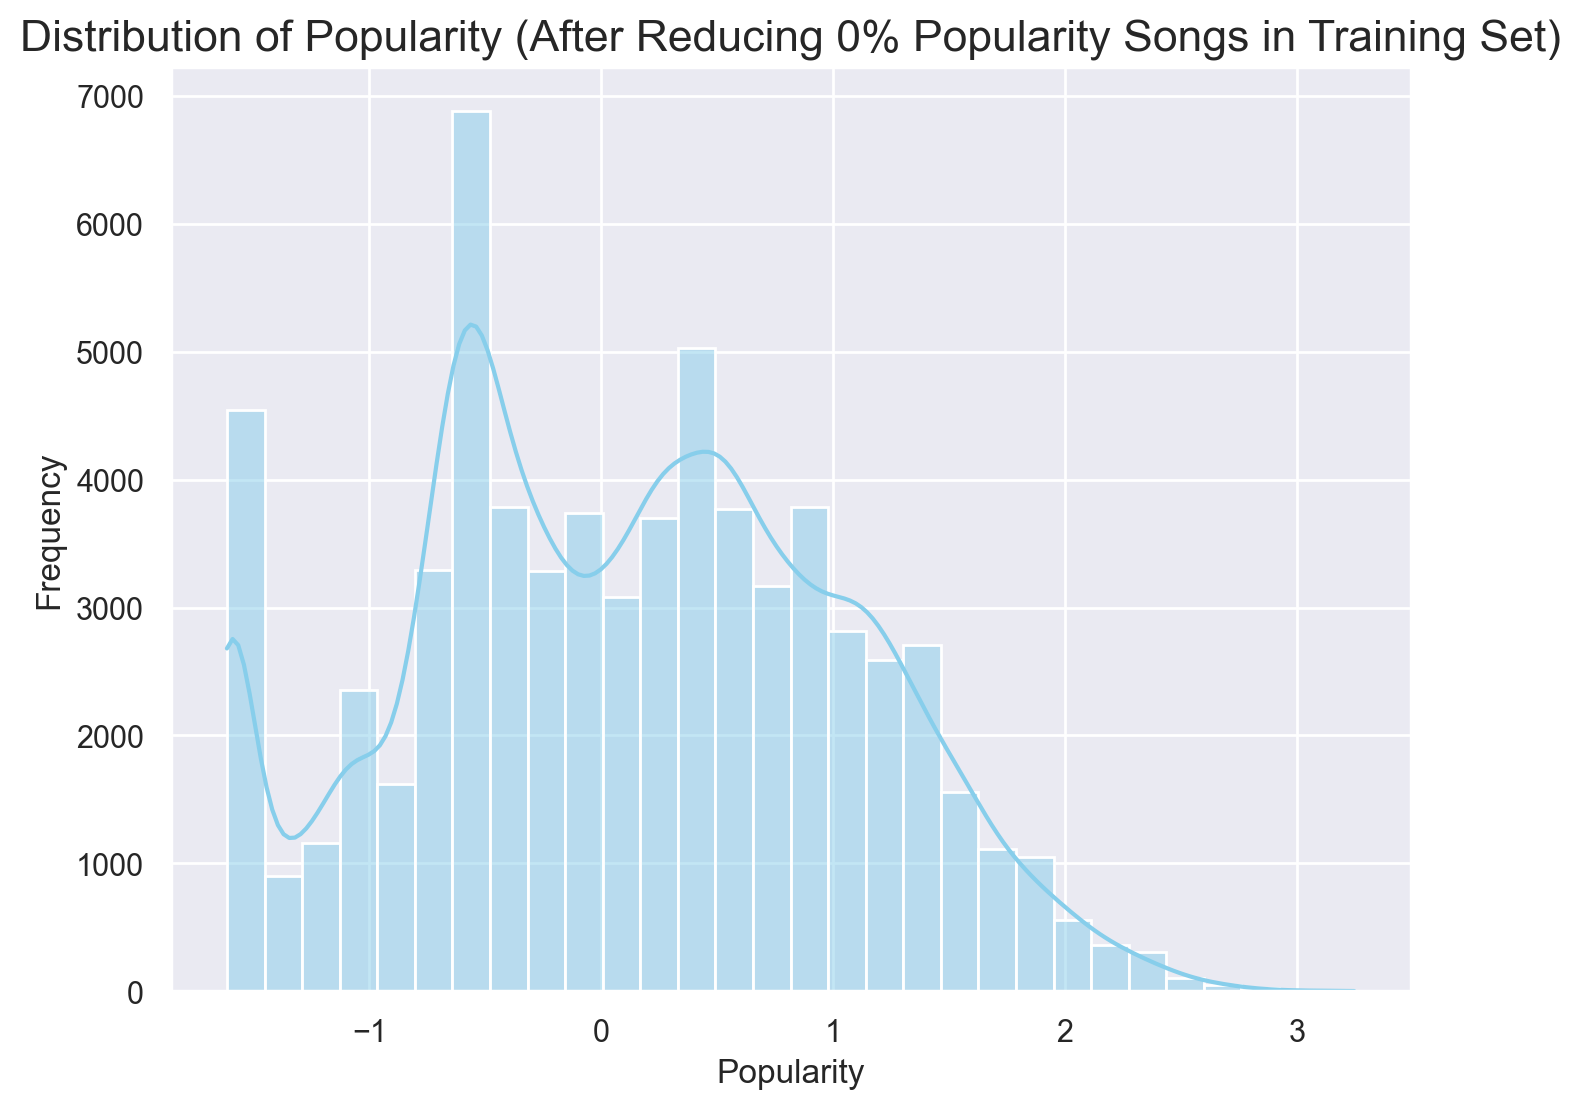

New distribution of popularity in the training set: popularity_flag
0    38348
1    29011
Name: count, dtype: int64
13946    0
70533    0
43788    0
44188    0
39434    0
        ..
6265     0
54886    1
76820    0
860      0
15795    1
Name: popularity_flag, Length: 67359, dtype: int64


In [34]:
from sklearn.utils import resample
# add 'popularity' back to X_train for resampling
X_train["popularity"] = scaled_df["popularity"]
X_train["popularity_flag"] = scaled_df["popularity_flag"]

# combine X_train and y_train back together for resampling
train_data = X_train
# define the threshold for the lower 1% in the scaled data
threshold = -1.6 

# separate the songs in the training set by popularity using the scaled data threshold
low_popularity_songs = train_data[train_data["popularity"] < threshold]
high_popularity_songs = train_data[train_data["popularity"] >= threshold]

# check the number of songs in each group
print(f"Low popularity songs count in training data: {len(low_popularity_songs)}")
print(f"High popularity songs count in training data: {len(high_popularity_songs)}")

# decide how many low-popularity songs to sample 
n_samples = 3000

# undersample the low popularity songs in the training set to reduce their number
low_popularity_songs_undersampled = resample(low_popularity_songs,
                                             replace=False,  
                                             n_samples=n_samples,  
                                             random_state=42)  

# combine the undersampled low popularity songs with the high popularity songs
train_data_balanced = pd.concat([low_popularity_songs_undersampled, high_popularity_songs])

# plotting the distribution of 'popularity' in the balanced training dataset
plt.figure(figsize=(8, 6))
sns.histplot(train_data_balanced["popularity"], kde=True, bins=30, color='skyblue')

# adding title and labels
plt.title('Distribution of Popularity (After Reducing 0% Popularity Songs in Training Set)', fontsize=16)
plt.xlabel('Popularity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# show the plot
plt.show()
# separate the features (X) and target variable (y) again (dropping 'popularity' for features)
X_train_balanced = train_data_balanced.drop(columns=["popularity","popularity_flag"])
y_train_balanced = train_data_balanced["popularity_flag"]

X_train = X_train_balanced
y_train = y_train_balanced
# check the new distribution of popularity values in the training data
print(f"New distribution of popularity in the training set: {y_train_balanced.value_counts()}")


print(y_train_balanced)

# **Model Training**
## Decision Tree


       duration_ms  explicit  danceability    energy  loudness      mode  \
13946    -0.469621 -0.306447      0.451826 -1.092958  0.318299  0.754933   
70533    -0.221562 -0.306447      0.066974 -1.307295 -0.116443 -1.324621   
43788    -1.552651 -0.306447     -1.862949  1.327104  0.307765  0.754933   
44188     1.193921 -0.306447     -2.083673 -0.952665 -1.922633  0.754933   
39434    -0.098316  3.263203      0.870636  0.458064  0.956623 -1.324621   
...            ...       ...           ...       ...       ...       ...   
6265     -0.571723 -0.306447     -0.176389  0.306080  0.991862  0.754933   
54886     0.906658 -0.306447     -1.410181  0.068360 -0.690417 -1.324621   
76820    -0.714191 -0.306447     -0.951754  1.327104  0.864312  0.754933   
860      -0.718440 -0.306447     -0.448050  1.401148  0.349133 -1.324621   
15795    -0.154751 -0.306447      0.978169  0.738651  0.834244 -1.324621   

       speechiness  acousticness  instrumentalness  liveness   valence  \
13946    -0.5

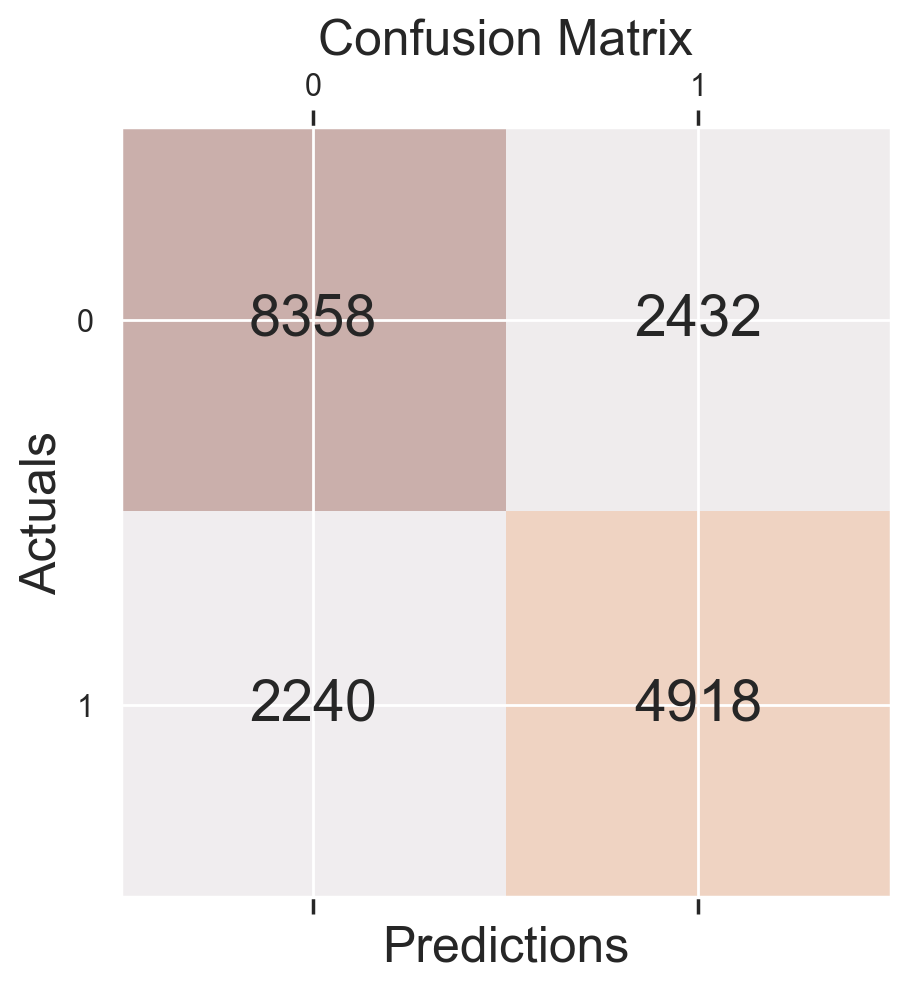

In [35]:
dt = DecisionTreeClassifier(random_state=1234)
dt.fit(X_train, y_train_balanced)
print(X_train)
y_train_preddt = dt.predict(X_train)
y_test_preddt = dt.predict(X_test)


conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_test_preddt)

# printing the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


# **Model Evaluation: Confusion Matrix and Metrics**

### Confusion Matrix Overview

The confusion matrix shown below represents the performance of our binary classification model:

- **True Negatives (TN)**: ~8366 (Correctly predicted that the song is not popular)
- **False Positives (FP)**: ~2424 (Incorrectly predicted that a song is popular when it's not)
- **False Negatives (FN)**: ~2243 (Incorrectly predicted that a song is not popular when it is)
- **True Positives (TP)**: ~4915 (Correctly predicted that the song is popular)


### Performance Metrics

####  **Accuracy**
Accuracy is the fraction of correct predictions (both true positives and true negatives) over the total number of predictions:

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$


####  **Weighted F1 Score**
The **weighted F1 score** takes into account the support (the number of true instances) of each class, and gives more weight to the class with more instances:

$$
\text{Weighted F1 Score} = \frac{\sum_{i} w_i \times F1_i}{\sum_{i} w_i}
$$

Where $w_i$ is the support of each class.
####  **Macro F1 Score**
The **macro F1 score** is the average of the F1 scores of both classes, treating each class equally regardless of its frequency:

$$
\text{Macro F1 Score} = \frac{1}{2} \left( \frac{TP_0}{TP_0 + FP_0 + FN_0} + \frac{TP_1}{TP_1 + FP_1 + FN_1} \right)
$$



---

### Why Accuracy is Not Suitable

Given the **class imbalance** in the dataset (where the majority of songs are not popular), accuracy alone may not reflect the model's true performance. A model that simply predicts "not popular" for every song would achieve a high accuracy but fail to identify the actual popular songs. This is why metrics like **precision**, **recall**, **F1 score**, and their variants (weighted or macro) are better suited for evaluating the model's performance in such scenarios.

The **weighted F1 score** and **macro F1 score** are particularly important because they provide a more comprehensive view of model performance across both classes, ensuring that the minority class (popular songs) is not ignored.


In [36]:
# extracting values from the confusion matrix
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

# accuracy
accuracy = (TN + TP) / (TN + TP + FP + FN)
print("Accuracy: ", accuracy)

# Precision
precision = TP / (TP + FP)
print("Precision: ", precision)

# Recall
recall = TP / (TP + FN)
print("Recall: ", recall)

# F1 Score
print("F1 Score:", f1_score(y_test, y_test_preddt))

Accuracy:  0.7396924448406508
Precision:  0.6691156462585034
Recall:  0.6870634255378597
F1 Score: 0.6779707747449683


- **Precision**:
$$
\frac{4918}{4918 + 2432} = 0.669
$$

- **Recall**:
$$
\frac{4918}{4918 + 2240} = 0.687
$$

- **F1 Score**:
$$
2 \times \frac{0.672 \times 0.693}{0.672 + 0.693} = 0.678
$$

In [37]:
print(metrics.classification_report(y_test, y_test_preddt))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     10790
           1       0.67      0.69      0.68      7158

    accuracy                           0.74     17948
   macro avg       0.73      0.73      0.73     17948
weighted avg       0.74      0.74      0.74     17948



In [38]:
weighted_f1 = f1_score(y_test, y_test_preddt, average='weighted')
weighted_f1

0.7402465200537783

In [39]:
macro_f1 = f1_score(y_test, y_test_preddt, average='macro')

macro_f1

0.729765263938783

## **Evaluation:**
- The **Decision Tree** model performs well in classifying the majority class (not popular songs), with high precision and recall. However, its performance in identifying the minority class (popular songs) could be improved, as reflected by the lower precision, recall, and F1-score for class 1.
- The **weighted average** metrics suggest the model handles the class imbalance reasonably well but could still benefit from further improvements in identifying popular songs.


# Random forest

Our second model is Random Forest, The training data goes through a sequence of decision trees. The data is bootstrapped and goes through 1000 decision trees (`n_estimators=1000`)

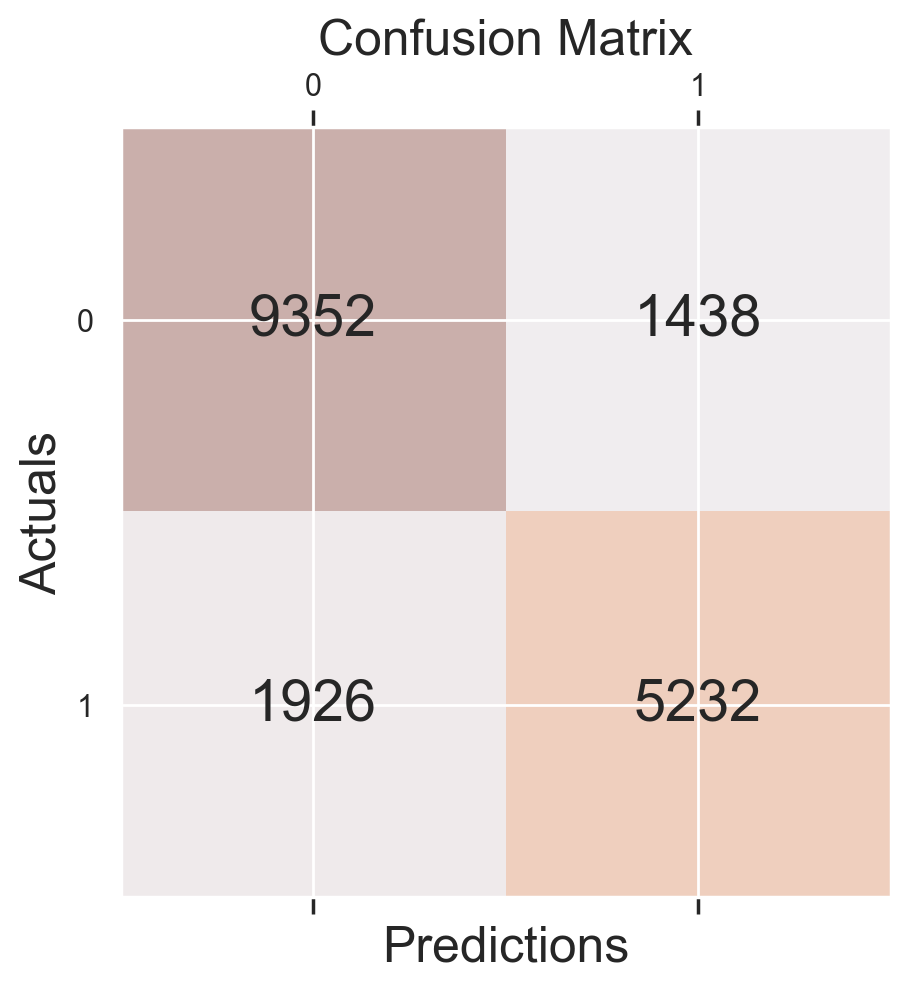

In [40]:
rf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train, y_train)
y_train_predrf = rf.predict(X_train)
y_test_predrf = rf.predict(X_test)

conf_matrix_rf = confusion_matrix(y_true=y_test, y_pred=y_test_predrf)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_rf, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_rf.shape[0]):
    for j in range(conf_matrix_rf.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_rf[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Performance: Our RF model performs slightly better, as $Accuracy=\frac{TP+TN}{TP+TN+FP+FN}=0.8119$, $Precision=\frac{TP}{TP+FP}=0.7831$, $Recall=\frac{TP}{TP+FN}=0.7309$, which leads us to a F1-score of 0.7561

In [41]:
# Extracting values from the confusion matrix
TN = conf_matrix_rf[0, 0]
FP = conf_matrix_rf[0, 1]
FN = conf_matrix_rf[1, 0]
TP = conf_matrix_rf[1, 1]

# Accuracy
accuracy = (TN + TP) / (TN + TP + FP + FN)
print("Accuracy: ", accuracy)

# Precision
precision = TP / (TP + FP)
print("Precision: ", precision)

# Recall
recall = TP / (TP + FN)
print("Recall: ", recall)

# F1 Score
f1 = f1_score(y_test, y_test_predrf)
print("F1 Score:", f1)

Accuracy:  0.8125696456429686
Precision:  0.784407796101949
Recall:  0.7309304274937133
F1 Score: 0.7567254845241539


In [42]:
weighted_f1 = f1_score(y_test, y_test_predrf, average='weighted')

print(f"Weighted F1 Score: {weighted_f1}")

Weighted F1 Score: 0.8113347376030019


In [43]:
macro_f1 = f1_score(y_test, y_test_predrf, average='macro')

print(f"Macro F1 Score: {macro_f1}")

Macro F1 Score: 0.8021437826825953


# K-Nearest-Neighbors

K-Nearest-Neighbors (KNN) is an algorithm based on the proximity between each points of data. We use the minmax scaling.

In [44]:
X_mm = minmax_df.drop(columns=["popularity", "popularity_flag"])
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_mm,y_target , train_size=0.80, random_state=12345)
X_train.shape, X_test.shape

((67359, 143), (17948, 143))

We set the number of neighbors at 5 (default value)

Best N_NEIGH: 19
Best weighted F1-score: 0.7770

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     10827
           1       0.74      0.69      0.71      7121

    accuracy                           0.78     17948
   macro avg       0.77      0.76      0.77     17948
weighted avg       0.78      0.78      0.78     17948



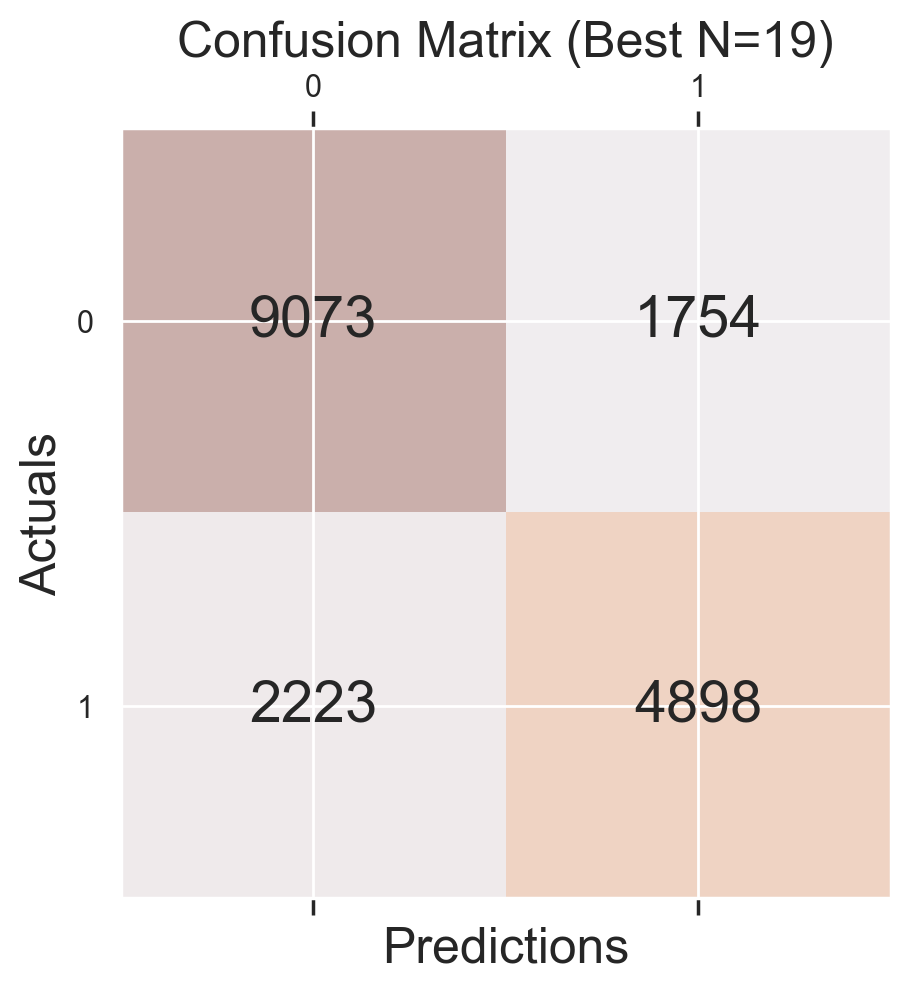

In [45]:
best_score = 0
best_n = None
best_model = None
best_y_pred = None
best_conf_matrix = None

for N_NEIGH in range(5, 21):
    knn = KNeighborsClassifier(n_neighbors=N_NEIGH)
    knn.fit(X_train_mm, y_train_mm)
    y_test_predknn = knn.predict(X_test_mm)
    
    score_w = f1_score(y_test_mm, y_test_predknn, average='weighted')
    
    if score_w > best_score:
        best_score = score_w
        best_n = N_NEIGH
        best_model = knn
        best_y_pred = y_test_predknn
        best_conf_matrix = confusion_matrix(y_test_mm, y_test_predknn)

# Display best results
print(f"Best N_NEIGH: {best_n}")
print(f"Best weighted F1-score: {best_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_mm, best_y_pred))

# Plot best confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(best_conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(best_conf_matrix.shape[0]):
    for j in range(best_conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=best_conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title(f'Confusion Matrix (Best N={best_n})', fontsize=18)
plt.show()


In [99]:
y_test_predkn = best_y_pred

# Logistic Regression

Logistic Regression is a widely used statistical model for binary and multi-class classification tasks. It predicts the probability of a categorical dependent variable by modeling the relationship between input features and the log-odds of the outcome. Unlike linear regression, logistic regression uses the sigmoid function, e.g. $f(x)=\frac{e^x}{1+e^x}$ (also called logit) to map predicted values to a range between 0 and 1, making it suitable for probability estimation.

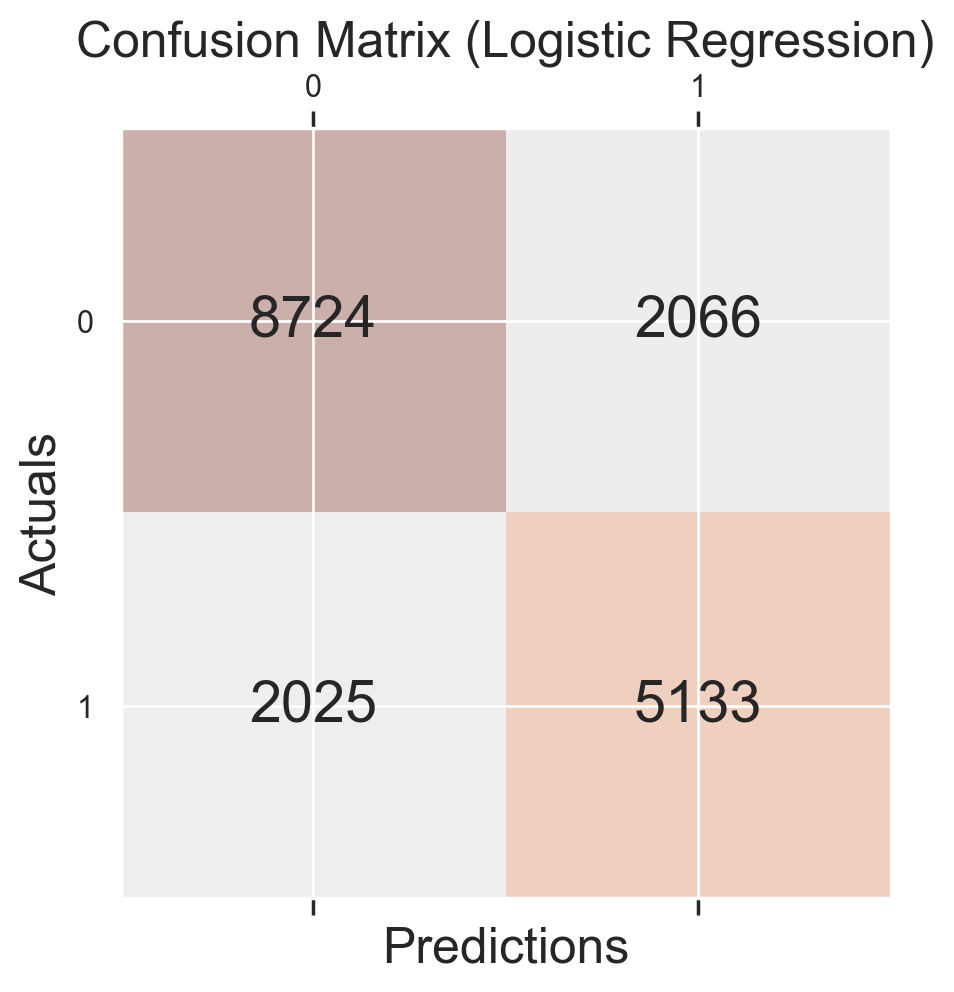

Accuracy:  0.7720637396924448
Precision:  0.8085264133456904
Recall:  0.8116103823611499
F1 Score: 0.7150518910635927
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     10790
           1       0.71      0.72      0.72      7158

    accuracy                           0.77     17948
   macro avg       0.76      0.76      0.76     17948
weighted avg       0.77      0.77      0.77     17948



In [97]:

# Initialize and train the Logistic Regression model
logreg = LogisticRegression(random_state=1234) #setting the seed at 1234
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test)

# Evaluate the model
conf_matrix_logreg = confusion_matrix(y_true=y_test, y_pred=y_pred_logreg)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_logreg, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_logreg.shape[0]):
    for j in range(conf_matrix_logreg.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix_logreg[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix (Logistic Regression)', fontsize=18)
plt.show()

# Performance metrics
print("Accuracy: ", (conf_matrix_logreg[0,0]+conf_matrix_logreg[1,1])/(conf_matrix_logreg[0,0]+conf_matrix_logreg[1,1]+conf_matrix_logreg[0,1]+conf_matrix_logreg[1,0]) )
print("Precision: ", (conf_matrix_logreg[0,0])/(conf_matrix_logreg[0,0]+conf_matrix_logreg[0,1]) )
print("Recall: ", (conf_matrix_logreg[0,0])/(conf_matrix_logreg[0,0]+conf_matrix_logreg[1,0]) )
print("F1 Score:", f1_score(y_test, y_pred_logreg))
print(metrics.classification_report(y_test, y_pred_logreg))

# Gaussian Naive Bayes

Gaussian Naive Bayes is a probabilistic machine learning algorithm based on Bayes' theorem, specifically designed for classification tasks. It assumes that the features follow a Gaussian (normal) distribution, making it particularly suitable for datasets where this assumption holds true. Despite its simplicity, Gaussian Naive Bayes is computationally efficient and often performs well on smaller datasets or problems with independent features.



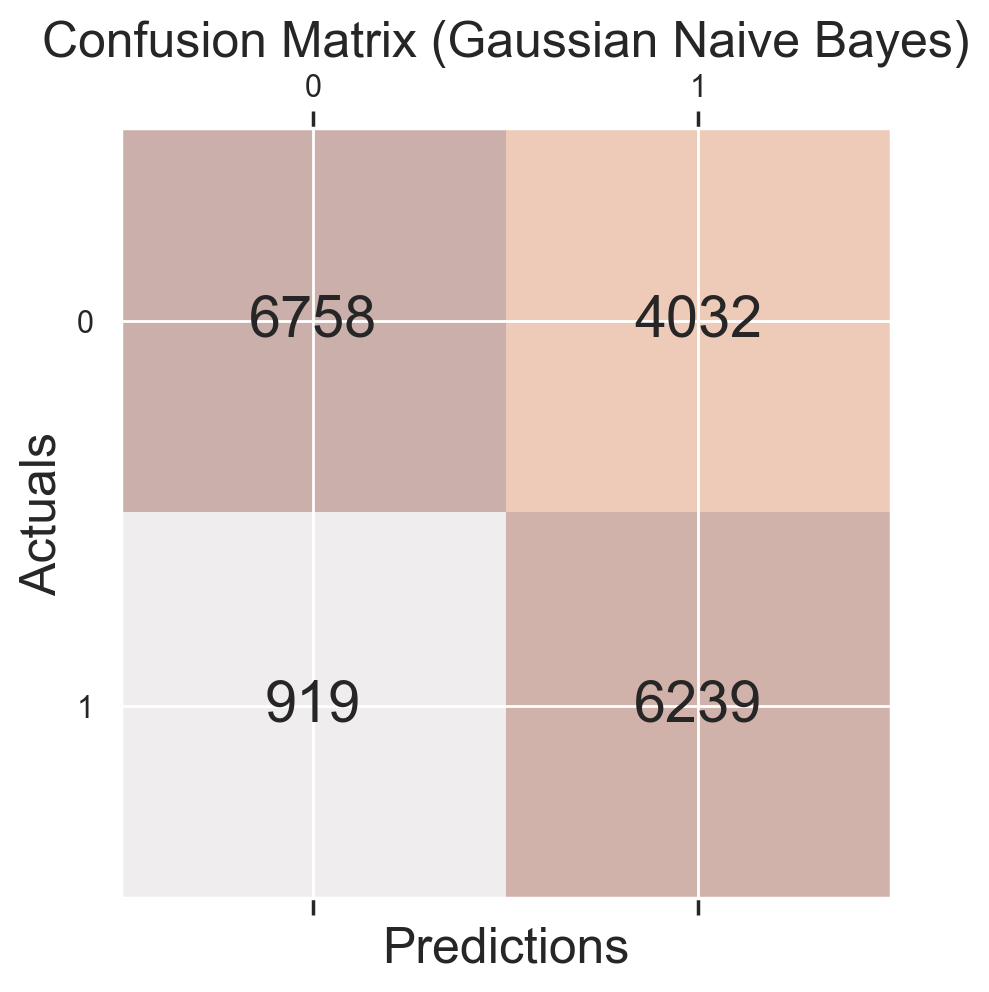

Accuracy:  0.7241475373300647
Precision:  0.6263206672845227
Recall:  0.8802917806434806
F1 Score: 0.7159332147570142


In [98]:
# initialize and train the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# make predictions on the test set
y_pred_gnb = gnb.predict(X_test)

# evaluate the model
conf_matrix_gnb = confusion_matrix(y_true=y_test, y_pred=y_pred_gnb)

# print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_gnb, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_gnb.shape[0]):
    for j in range(conf_matrix_gnb.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix_gnb[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix (Gaussian Naive Bayes)', fontsize=18)
plt.show()

# performance metrics
print("Accuracy: ", (conf_matrix_gnb[0,0]+conf_matrix_gnb[1,1])/(conf_matrix_gnb[0,0]+conf_matrix_gnb[1,1]+conf_matrix_gnb[0,1]+conf_matrix_gnb[1,0]) )
print("Precision: ", (conf_matrix_gnb[0,0])/(conf_matrix_gnb[0,0]+conf_matrix_gnb[0,1]) )
print("Recall: ", (conf_matrix_gnb[0,0])/(conf_matrix_gnb[0,0]+conf_matrix_gnb[1,0]) )
print("F1 Score:", f1_score(y_test, y_pred_gnb))

Let's recap, here's the plot of our f1 metrics across all of the models

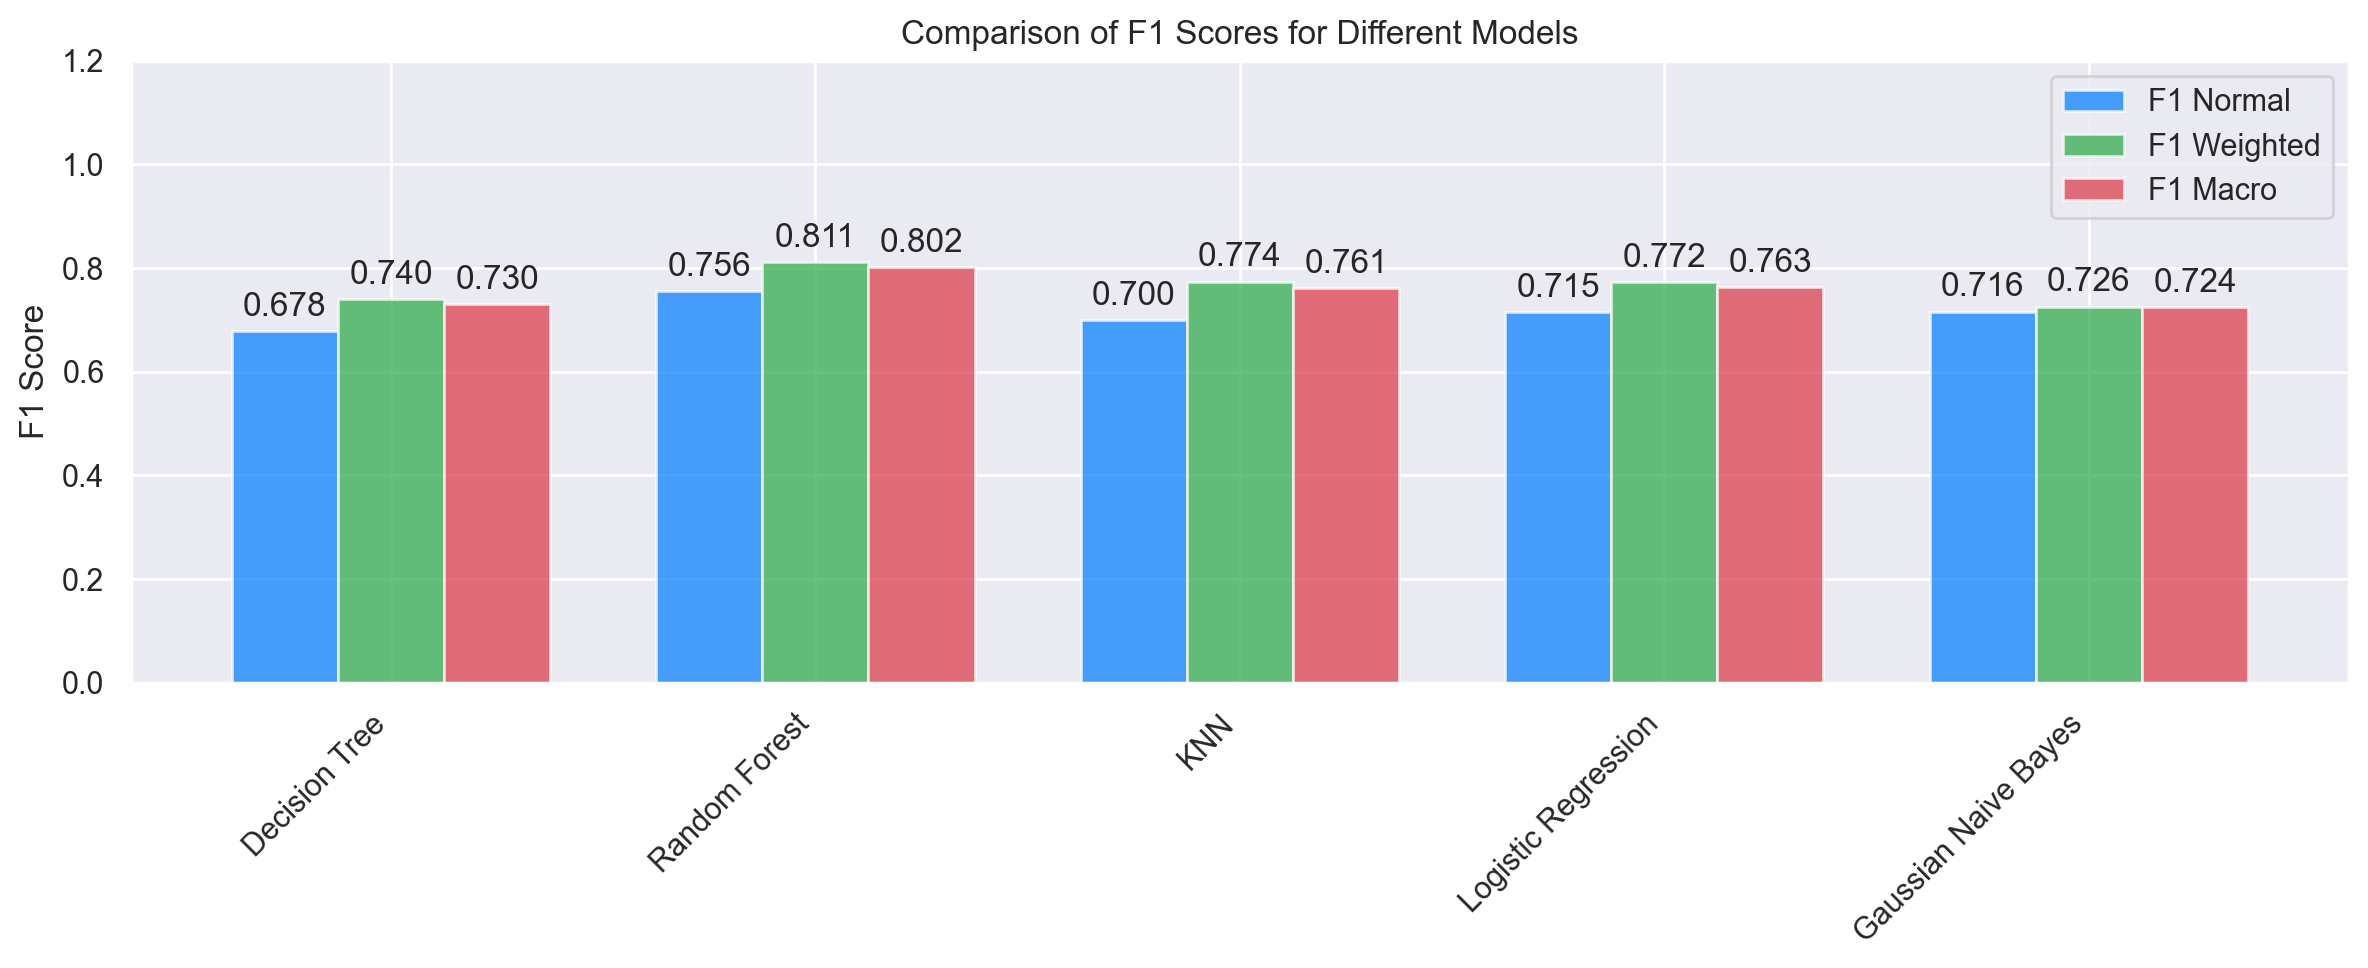

In [100]:
models = ['Decision Tree', 'Random Forest', 'KNN', 'Logistic Regression', 'Gaussian Naive Bayes']
f1_normal = [f1_score(y_test, y_test_preddt), f1_score(y_test, y_test_predrf), f1_score(y_test_mm, y_test_predknn), f1_score(y_test, y_pred_logreg), f1_score(y_test, y_pred_gnb)]
f1_weighted = [f1_score(y_test, y_test_preddt, average='weighted'), f1_score(y_test, y_test_predrf, average='weighted'), f1_score(y_test_mm, y_test_predknn, average='weighted'), f1_score(y_test, y_pred_logreg, average='weighted'), f1_score(y_test, y_pred_gnb, average='weighted')]
f1_macro =[f1_score(y_test, y_test_preddt, average='macro'), f1_score(y_test, y_test_predrf, average='macro'),f1_score(y_test_mm, y_test_predknn, average='macro'), f1_score(y_test, y_pred_logreg, average='macro'), f1_score(y_test, y_pred_gnb, average='macro')]

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 5))
rects1 = ax.bar(x - width, f1_normal, width, label='F1 Normal', color='#007bff', alpha=0.7) # Blue
rects2 = ax.bar(x, f1_weighted, width, label='F1 Weighted', color='#28a745', alpha=0.7) # Green
rects3 = ax.bar(x + width, f1_macro, width, label='F1 Macro', color='#dc3545', alpha=0.7) # Red


ax.set_ylim(0, 1.2)
ax.set_ylabel('F1 Score')
ax.set_title('Comparison of F1 Scores for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', # Format the annotation to 3 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

# **Conclusion**
The Random Forest model is the most suitable to predict the popularity of a song, offering the best balance of precision and recall across all versions of f1 scores. Logistic Regression is a strong alternative with competitive performance. Other models like Gaussian Naive Bayes, KNN, and Decision Tree are less effective and might require further tuning or additional feature engineering to improve their performance.




*Limitations and possible improvments* :
      
- Models can be fine-tuned (with `GridSearch` for example) to find the best hyperparameters that maximize our performance metrics.
- Testing phase: models could be tested on other data outside those in `dataset.csv` to ensure that our models perform well on new data.
- The threshold set arbitrarily at 50 then 40 could also be improved.
- the number of low-popularity songs after resampling (referred to as `n_samples=3000`) can also be optimized. It shouldn't be so low in order not to overfit our models but it shouldn't also be so high to keep our data balanced.  


